---
Reinforcement Learning for Generation of Novel Non-toxic Molecules
---
**William Ladd, Pooja Parameswaran, Rutwik Palaskar**

Final Project for BME 590L Machine Learning in Pharmacology Fall 2022

---


For our project we used reinforcement learning to generate novel non-toxic molecules. Reinforcement learning is implemented using an existing code library [ReLeaSe](https://github.com/isayev/ReLeaSE) from a paper, [Deep reinforcement learning for de novo drug design by Popova et al.](https://doi.org/10.1126/sciadv.aap7885) published in 2018 in Science Advances. We provide a predictive model and ReLeaSE provides a generative model (a Recurrent Neural Network (RNN)) and the reinforcement framework (code that takes the predictive model, generative model, and a reward function and runs the reinforcement learning).

This notebook is broken into 4 main sections:
- Notebook Setup
- ReLeaSE Library Imports
- Predictive Model Comparison, Analysis, and Selection
- Reinforcement Learning

Our goal for this project is to create novel molecules that are majority non-toxic. We classify non-toxic with a class value of zero (0). In order to establish this, we create a Reinforcement Model with a Predictor, Generator, and reward function.

---
Notebook Setup
===
---
**Please upload the accompanying files from `Files_for_Notebook.zip` to the google colab environment before running the code.** The following lines

In [ ]:
%%capture 
"""Install all Necessary Modules"""
!pip install tqdm
!pip install deepchem
!pip install rdkit-"pypi"
!pip install PyTDC # TDC dataset
!pip install mordred

In [ ]:
"""Import most Necessary Modules"""

import scipy
import numpy as np 
import pandas as pd
import seaborn as sn 
import deepchem as dc
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import metrics
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import (
    AllChem,
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys
)
%matplotlib inline 

---
ReLeaSE Library Imports
===
---
The following few blocks contain the code of .py files from [ReLeaSE](https://github.com/isayev/ReLeaSE/tree/master/release), they are denoted by the comment at the top of the block.

In [ ]:
########################################## DONE
# data.py from ReLeaSe 
# https://github.com/isayev/ReLeaSE/blob/master/release/data.py
##########################################

import torch
import random
import numpy as np

class GeneratorData(object):
    """
    Generating objects being used to read and load data into Generator and Predictor
    """
    def __init__(self, training_data_path, tokens=None, start_token='<', 
                 end_token='>', max_len=120, use_cuda=None, **kwargs):
        """
        Constructor for the GeneratorData object.
        Parameters
        ----------
        training_data_path: str
            path to file with training dataset. Training dataset must contain
            a column with training strings. The file also may contain other
            columns.
        tokens: list (default None)
            list of characters specifying the language alphabet. Of left
            unspecified, tokens will be extracted from data automatically.
        start_token: str (default '<')
            special character that will be added to the beginning of every
            sequence and encode the sequence start.
        end_token: str (default '>')
            special character that will be added to the end of every
            sequence and encode the sequence end.
        max_len: int (default 120)
            maximum allowed length of the sequences. All sequences longer than
            max_len will be excluded from the training data.
        use_cuda: bool (default None)
            parameter specifying if GPU is used for computations. If left
            unspecified, GPU will be used if available
        kwargs: additional positional arguments
            These include cols_to_read (list, default [0]) specifying which
            column in the file with training data contains training sequences
            and delimiter (str, default ',') that will be used to separate
            columns if there are multiple of them in the file.
        """
        super(GeneratorData, self).__init__()
        # Columns to read from csv file
        if 'cols_to_read' not in kwargs:
            kwargs['cols_to_read'] = []

        # data from training path
        data = read_object_property_file(training_data_path,
                                                       **kwargs)
        self.start_token = start_token
        self.end_token = end_token
        self.file = []
        # Start and end of data
        for i in range(len(data)):
            if len(data[i]) <= max_len:
                self.file.append(self.start_token + data[i] + self.end_token) 
        self.file_len = len(self.file)
        self.all_characters, self.char2idx, \
        self.n_characters = tokenize(self.file, tokens)
        self.use_cuda = use_cuda
        if self.use_cuda is None:
            self.use_cuda = torch.cuda.is_available()

    def load_dictionary(self, tokens, char2idx):
        """
        Load dictionary

        """
        self.all_characters = tokens
        self.char2idx = char2idx
        self.n_characters = len(tokens)

    def random_chunk(self):
        """
        Samples random SMILES string from generator training data set.
        Returns:
            random_smiles (str).
        """
        index = random.randint(0, self.file_len-1)
        return self.file[index]

    def char_tensor(self, string):
        """
        Converts SMILES into tensor of indices wrapped into torch.autograd.Variable.
        Args:
            string (str): input SMILES string
        Returns:
            tokenized_string (torch.autograd.Variable(torch.tensor))
        """
        tensor = torch.zeros(len(string)).long()
        for c in range(len(string)):
            tensor[c] = self.all_characters.index(string[c])
        if self.use_cuda:
            return torch.tensor(tensor).cuda()
        else:
            return torch.tensor(tensor)

    def random_training_set(self, smiles_augmentation):
        chunk = self.random_chunk()
        if smiles_augmentation is not None:
            chunk = '<' + smiles_augmentation.randomize_smiles(chunk[1:-1]) + '>'
        inp = self.char_tensor(chunk[:-1])
        target = self.char_tensor(chunk[1:])
        return inp, target

    def read_sdf_file(self, path, fields_to_read):
        raise NotImplementedError
        
    def update_data(self, path):
        """
        Update file path to smiles data

        """
        self.file, success = read_smi_file(path, unique=True)
        self.file_len = len(self.file)
        assert success


class PredictorData(object):
    """
    Loads data for Predictor Model
    """
    def __init__(self, path, delimiter=',', cols=[0,13], get_features=None,
                 has_label=True, labels_start=1, **kwargs):
        super(PredictorData, self).__init__()
        data = read_object_property_file(path, delimiter, cols_to_read=cols)
        if has_label:
            self.objects = np.array(data[:labels_start]).reshape(-1)
            self.y = np.array(data[labels_start:], dtype='float32')
            self.y = self.y.reshape(-1, len(cols) - labels_start)
            if self.y.shape[1] == 1:
                self.y = self.y.reshape(-1)
        else:
            self.objects = np.array(data[:labels_start]).reshape(-1)
            self.y = [None]*len(self.object)
        assert len(self.objects) == len(self.y)
        if get_features is not None:
            self.x, processed_indices, invalid_indices = \
                get_features(self.objects, **kwargs)
            self.invalid_objects = self.objects[invalid_indices]
            self.objects = self.objects[processed_indices]
            self.invalid_y = self.y[invalid_indices]
            self.y = self.y[processed_indices]
        else:
            self.x = self.objects
            self.invalid_objects = None
            self.invalid_y = None
        self.binary_y = None

    def binarize(self, threshold):
        self.binary_y = np.array(self.y >= threshold, dtype='int32')

In [ ]:
########################################## 
# predictor.py from ReLeaSe 
# https://github.com/isayev/ReLeaSE/blob/master/release/predictor.py
##########################################
# Note: This code was adapted to calculate prediction model performance  
# statistics.
#
#

from __future__ import print_function
from __future__ import division

import numpy as np

from joblib import dump, load
from sklearn import metrics




class VanillaQSAR(object):
    """
    Create Predictor Model to make classification models 
    Has the following functions:
      fit_model, load_model, save_model, predict
    Appended code to evaluate model performance with the following metrics: 
      f1_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score, matthews_corrcoef

    """
    def __init__(self, model_instance=None, model_params=None,
                 model_type='classifier', ensemble_size=5, normalization=False):
        super(VanillaQSAR, self).__init__()
        self.model_instance = model_instance
        self.model_params = model_params
        self.ensemble_size = ensemble_size
        self.model = []
        self.normalization = normalization
        if model_type not in ['classifier', 'regressor']:
            raise InvalidArgumentError("model type must be either"
                                       "classifier or regressor")
        self.model_type = model_type
        if isinstance(self.model_instance, list):
            assert(len(self.model_instance) == self.ensemble_size)
            assert(isinstance(self.model_params, list))
            assert(len(self.model_params) == self.ensemble_size)
            for i in range(self.ensemble_size):
                self.model.append(self.model_instance[i](**model_params[i]))
        else:
            for _ in range(self.ensemble_size):
                self.model.append(self.model_instance(**model_params))
        if self.normalization:
            self.desc_mean = [0]*self.ensemble_size
        self.metrics_type = None

    def fit_model(self, data, cv_split='stratified'):
        """
        Fit model to prediction data and calculate indicated metrics
        """
        eval_metrics = []
        eval_metrics2 = []
        eval_metrics3 = []
        eval_metrics4 = []
        eval_metrics5 = []
        eval_metrics6 = []
        eval_metrics7 = []

        x = data.x
        if self.model_type == 'classifier' and data.binary_y is not None:
            y = data.binary_y
        else:
            y = data.y
        cross_val_data, cross_val_labels = cross_validation_split(x=x, y=y,
                                                                  split=cv_split,
                                                                  n_folds=self.ensemble_size)
        for i in range(self.ensemble_size):
            train_x = np.concatenate(cross_val_data[:i] +
                                     cross_val_data[(i + 1):])
            test_x = cross_val_data[i]
            train_y = np.concatenate(cross_val_labels[:i] +
                                     cross_val_labels[(i + 1):])
            test_y = cross_val_labels[i]
            if self.normalization:
                train_x, desc_mean = normalize_desc(train_x)
                self.desc_mean[i] = desc_mean
                test_x, _ = normalize_desc(test_x, desc_mean)
            self.model[i].fit(train_x, train_y.ravel())
            predicted = self.model[i].predict(test_x)
            if self.model_type == 'classifier':
                eval_metrics.append(metrics.f1_score(test_y, predicted))
                self.metrics_type = 'F1 score'
                eval_metrics2.append(metrics.accuracy_score(test_y, predicted))
                self.metrics_type2 = 'Test Accuracy score'
                eval_metrics3.append(metrics.balanced_accuracy_score(test_y, predicted))
                self.metrics_type3 = 'Balanced Accuracy Score'
                eval_metrics4.append(metrics.recall_score(test_y, predicted))
                self.metrics_type4 = 'Recall Score'
                eval_metrics5.append(metrics.precision_score(test_y, predicted))
                self.metrics_type5 = 'Precision Score'
                eval_metrics6.append(metrics.roc_auc_score(test_y, predicted))
                self.metrics_type6 = 'AUC-ROC Score'
                eval_metrics7.append(metrics.matthews_corrcoef(test_y, predicted))
                self.metrics_type7 = 'Matthews Correlation Coefficient'


            elif self.model_type == 'regressor':
                r2 = metrics.r2_score(test_y, predicted)
                eval_metrics.append(r2)
                self.metrics_type = 'R^2 score'
            else:
                raise RuntimeError()
        finallist = [eval_metrics,self.metrics_type,eval_metrics2,self.metrics_type2,eval_metrics3,self.metrics_type3,eval_metrics4,self.metrics_type4,eval_metrics5,self.metrics_type5,eval_metrics6,self.metrics_type6, eval_metrics7, self.metrics_type7]
        return eval_metrics,self.metrics_type,eval_metrics2,self.metrics_type2,eval_metrics3,self.metrics_type3,eval_metrics4,self.metrics_type4,eval_metrics5,self.metrics_type5,eval_metrics6,self.metrics_type6, eval_metrics7, self.metrics_type7

    def load_model(self, path):
        # TODO: add iterable path object instead of static path 
        self.model = []
        for i in range(self.ensemble_size):
            m = joblib.load(path + str(i) + '.pkl')
            self.model.append(m)
        if self.normalization:
            arr = np.load(path + 'desc_mean.npy')
            self.desc_mean = arr

    def save_model(self, path):
        assert self.ensemble_size == len(self.model)
        for i in range(self.ensemble_size):
            joblib.dump(self.model[i], path + str(i) + '.pkl')
        if self.normalization:
            np.save(path + 'desc_mean.npy', self.desc_mean)

    def predict(self, objects=None, average=True, get_features=None,
                **kwargs):
        objects = np.array(objects)
        invalid_objects = []
        processed_objects = []
        if get_features is not None:
            x, processed_indices, invalid_indices = get_features(objects,
                                                                 **kwargs)
            processed_objects = objects[processed_indices]
            invalid_objects = objects[invalid_indices]
        else:
            x = objects
        if len(x) == 0:
            processed_objects = []
            prediction = []
            invalid_objects = objects
        else:
            prediction = []
            for i in range(self.ensemble_size):
                m = self.model[i]
                if self.normalization:
                    x, _ = normalize_desc(x, self.desc_mean[i])
                prediction.append(m.predict(x))
            prediction = np.array(prediction)
            if average:
                prediction = prediction.mean(axis=0)
        print(prediction)
        return processed_objects, prediction, invalid_objects



In [ ]:
########################################## 
# reinforcement.py from ReLeaSe 
# https://github.com/isayev/ReLeaSE/blob/master/release/reinforcement.py
##########################################

"""
This class implements simple policy gradient algorithm for
biasing the generation of molecules towards desired values of
properties aka Reinforcement Learninf for Structural Evolution (ReLeaSE)
as described in 
Popova, M., Isayev, O., & Tropsha, A. (2018). 
Deep reinforcement learning for de novo drug design. 
Science advances, 4(7), eaap7885.
"""

import torch
import torch.nn.functional as F
import numpy as np
from rdkit import Chem


class Reinforcement(object):
    def __init__(self, generator, predictor, get_reward):
        """
        Constructor for the Reinforcement object.
        Parameters
        ----------
        generator: object of type StackAugmentedRNN
            generative model that produces string of characters (trajectories)
        predictor: object of any predictive model type
            predictor accepts a trajectory and returns a numerical
            prediction of desired property for the given trajectory
        get_reward: function
            custom reward function that accepts a trajectory, predictor and
            any number of positional arguments and returns a single value of
            the reward for the given trajectory
            Example:
            reward = get_reward(trajectory=my_traj, predictor=my_predictor,
                                custom_parameter=0.97)
        Returns
        -------
        object of type Reinforcement used for biasing the properties estimated
        by the predictor of trajectories produced by the generator to maximize
        the custom reward function get_reward.
        """

        super(Reinforcement, self).__init__()
        self.generator = generator
        self.predictor = predictor
        self.get_reward = get_reward

    def policy_gradient(self, data, n_batch=10, gamma=0.97,
                        std_smiles=False, grad_clipping=None, **kwargs):
        """
        Implementation of the policy gradient algorithm.
        Parameters:
        -----------
        data: object of type GeneratorData
            stores information about the generator data format such alphabet, etc
        n_batch: int (default 10)
            number of trajectories to sample per batch. When training on GPU
            setting this parameter to to some relatively big numbers can result
            in out of memory error. If you encountered such an error, reduce
            n_batch.
        gamma: float (default 0.97)
            factor by which rewards will be discounted within one trajectory.
            Usually this number will be somewhat close to 1.0.
        std_smiles: bool (default False)
            boolean parameter defining whether the generated trajectories will
            be converted to standardized SMILES before running policy gradient.
            Leave this parameter to the default value if your trajectories are
            not SMILES.
        grad_clipping: float (default None)
            value of the maximum norm of the gradients. If not specified,
            the gradients will not be clipped.
        kwargs: any number of other positional arguments required by the
            get_reward function.
        Returns
        -------
        total_reward: float
            value of the reward averaged through n_batch sampled trajectories
        rl_loss: float
            value for the policy_gradient loss averaged through n_batch sampled
            trajectories
        """
        rl_loss = 0
        self.generator.optimizer.zero_grad()
        total_reward = 0
        
        for _ in range(n_batch):

            # Sampling new trajectory
            reward = 0
            trajectory = '<>'
            while reward == 0:
                trajectory = self.generator.evaluate(data)
                if std_smiles:
                    try:
                        mol = Chem.MolFromSmiles(trajectory[1:-1])
                        trajectory = '<' + Chem.MolToSmiles(mol) + '>'
                        reward = self.get_reward(trajectory[1:-1], 
                                                 self.predictor, 
                                                 **kwargs)
                    except:
                        reward = 0
                else:
                    reward = self.get_reward(trajectory[1:-1],
                                             self.predictor, 
                                             **kwargs)

            # Converting string of characters into tensor
            trajectory_input = data.char_tensor(trajectory)
            discounted_reward = reward
            total_reward += reward

            # Initializing the generator's hidden state
            hidden = self.generator.init_hidden()
            if self.generator.has_cell:
                cell = self.generator.init_cell()
                hidden = (hidden, cell)
            if self.generator.has_stack:
                stack = self.generator.init_stack()
            else:
                stack = None

            # "Following" the trajectory and accumulating the loss
            for p in range(len(trajectory)-1):
                output, hidden, stack = self.generator(trajectory_input[p], 
                                                       hidden, 
                                                       stack)
                log_probs = F.log_softmax(output, dim=1)
                top_i = trajectory_input[p+1]
                rl_loss -= (log_probs[0, top_i]*discounted_reward)
                discounted_reward = discounted_reward * gamma

        # Doing backward pass and parameters update
        rl_loss = rl_loss / n_batch
        total_reward = total_reward / n_batch
        rl_loss.backward()
        if grad_clipping is not None:
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), 
                                           grad_clipping)

        self.generator.optimizer.step()
        
        return total_reward, rl_loss.item()

In [ ]:
##########################################
# smiles_enumerator.py from ReLeaSe 
# https://github.com/isayev/ReLeaSE/blob/master/release/smiles_enumerator.py
##########################################

# Experimental Class for Smiles Enumeration, Iterator and SmilesIterator adapted from Keras 1.2.2
from rdkit import Chem
import numpy as np
import threading


class Iterator(object):
    """Abstract base class for data iterators.
    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(n, batch_size, shuffle, seed)
        if n < batch_size:
            raise ValueError('Input data length is shorter than batch_size\nAdjust batch_size')

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)


class SmilesIterator(Iterator):
    """Iterator yielding data from a SMILES array.
    # Arguments
        x: Numpy array of SMILES input data.
        y: Numpy array of targets data.
        smiles_data_generator: Instance of `SmilesEnumerator`
            to use for random SMILES generation.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        dtype: dtype to use for returned batch. Set to keras.backend.floatx if using Keras
    """

    def __init__(self, x, y, smiles_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dtype=np.float32
                 ):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        self.x = np.asarray(x)

        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.smiles_data_generator = smiles_data_generator
        self.dtype = dtype
        super(SmilesIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(
            tuple([current_batch_size] + [self.smiles_data_generator.pad, self.smiles_data_generator._charlen]),
            dtype=self.dtype)
        for i, j in enumerate(index_array):
            smiles = self.x[j:j + 1]
            x = self.smiles_data_generator.transform(smiles)
            batch_x[i] = x

        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y


class SmilesEnumerator(object):
    """SMILES Enumerator, vectorizer and devectorizer
    #Arguments
        charset: string containing the characters for the vectorization
          can also be generated via the .fit() method
        pad: Length of the vectorization
        leftpad: Add spaces to the left of the SMILES
        isomericSmiles: Generate SMILES containing information about stereogenic centers
        enum: Enumerate the SMILES during transform
        canonical: use canonical SMILES during transform (overrides enum)
    """

    def __init__(self, charset='@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True,
                 canonical=False):
        self._charset = None
        self.charset = charset
        self.pad = pad
        self.leftpad = leftpad
        self.isomericSmiles = isomericSmiles
        self.enumerate = enum
        self.canonical = canonical

    @property
    def charset(self):
        return self._charset

    @charset.setter
    def charset(self, charset):
        self._charset = charset
        self._charlen = len(charset)
        self._char_to_int = dict((c, i) for i, c in enumerate(charset))
        self._int_to_char = dict((i, c) for i, c in enumerate(charset))

    def fit(self, smiles, extra_chars=[], extra_pad=5):
        """Performs extraction of the charset and length of a SMILES datasets and sets self.pad and self.charset
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
            extra_chars: List of extra chars to add to the charset (e.g. "\\\\" when "/" is present)
            extra_pad: Extra padding to add before or after the SMILES vectorization
        """
        charset = set("".join(list(smiles)))
        self.charset = "".join(charset.union(set(extra_chars)))
        self.pad = max([len(smile) for smile in smiles]) + extra_pad

    def randomize_smiles(self, smiles):
        """Perform a randomization of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m, ans)
        return Chem.MolToSmiles(nm, canonical=self.canonical, isomericSmiles=self.isomericSmiles)

    def transform(self, smiles):
        """Perform an enumeration (randomization) and vectorization of a Numpy array of smiles strings
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
        """
        one_hot = np.zeros((smiles.shape[0], self.pad, self._charlen), dtype=np.int8)

        for i, ss in enumerate(smiles):
            if self.enumerate: ss = self.randomize_smiles(ss)
            for j, c in enumerate(ss):
                one_hot[i, j, self._char_to_int[c]] = 1
        return one_hot

    def reverse_transform(self, vect):
        """ Performs a conversion of a vectorized SMILES to a smiles strings
        charset must be the same as used for vectorization.
        #Arguments
            vect: Numpy array of vectorized SMILES.
        """
        smiles = []
        for v in vect:
            # mask v
            v = v[v.sum(axis=1) == 1]
            # Find one hot encoded index with argmax, translate to char and join to string
            smile = "".join(self._int_to_char[i] for i in v.argmax(axis=1))
            smiles.append(smile)
        return np.array(smiles)


if __name__ == "__main__":
    smiles = np.array(["CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2",
                       "CCC[S@@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2"] * 10
                      )
    # Test canonical SMILES vectorization
    sm_en = SmilesEnumerator(canonical=True, enum=False)
    sm_en.fit(smiles, extra_chars=["\\"])
    v = sm_en.transform(smiles)
    transformed = sm_en.reverse_transform(v)
    if len(set(transformed)) > 2: print("Too many different canonical SMILES generated")

    # Test enumeration
    sm_en.canonical = False
    sm_en.enumerate = True
    v2 = sm_en.transform(smiles)
    transformed = sm_en.reverse_transform(v2)
    if len(set(transformed)) < 3: print("Too few enumerated SMILES generated")

    # Reconstruction
    reconstructed = sm_en.reverse_transform(v[0:5])
    for i, smile in enumerate(reconstructed):
        if smile != smiles[i]:
            print("Error in reconstruction %s %s" % (smile, smiles[i]))
            break

    # test Pandas
    import pandas as pd

    df = pd.DataFrame(smiles)
    v = sm_en.transform(df[0])
    if v.shape != (20, 52, 18): print("Possible error in pandas use")

    # BUG, when batchsize > x.shape[0], then it only returns x.shape[0]!
    # Test batch generation
    sm_it = SmilesIterator(smiles, np.array([1, 2] * 10), sm_en, batch_size=10, shuffle=True)
    X, y = sm_it.next()
    if sum(y == 1) - sum(y == 2) > 1:
        print("Unbalanced generation of batches")
    if len(X) != 10: print("Error in batchsize generation")

In [ ]:
##########################################
# stackRNN.py from ReLeaSe 
# https://github.com/isayev/ReLeaSE/blob/master/release/stackRNN.py
##########################################
"""
This class implements generative recurrent neural network with augmented memory
stack as proposed in https://arxiv.org/abs/1503.01007
There are options of using LSTM or GRU, as well as using the generator without
memory stack.
"""

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import time
from tqdm import trange


class StackAugmentedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layer_type='GRU',
                 n_layers=1, is_bidirectional=False, has_stack=False,
                 stack_width=None, stack_depth=None, use_cuda=None,
                 optimizer_instance=torch.optim.Adadelta, lr=0.01):
        """
        Constructor for the StackAugmentedRNN object.
        Parameters
        ----------
        input_size: int
            number of characters in the alphabet
        hidden_size: int
            size of the RNN layer(s)
        output_size: int
            again number of characters in the alphabet
        layer_type: str (default 'GRU')
            type of the RNN layer to be used. Could be either 'LSTM' or 'GRU'.
        n_layers: int (default 1)
            number of RNN layers
        is_bidirectional: bool (default False)
            parameter specifying if RNN is bidirectional
        has_stack: bool (default False)
            parameter specifying if augmented memory stack is used
        stack_width: int (default None)
            if has_stack is True then this parameter defines width of the
            augmented stack memory
        stack_depth: int (default None)
            if has_stack is True then this parameter define depth of the augmented
            stack memory. Hint: no need fo stack depth to be larger than the
            length of the longest sequence you plan to generate
        use_cuda: bool (default None)
            parameter specifying if GPU is used for computations. If left
            unspecified, GPU will be used if available
        optimizer_instance: torch.optim object (default torch.optim.Adadelta)
            optimizer to be used for training
        lr: float (default 0.01)
            learning rate for the optimizer
        """
        super(StackAugmentedRNN, self).__init__()
        
        if layer_type not in ['GRU', 'LSTM']:
            raise InvalidArgumentError('Layer type must be GRU or LSTM')
        self.layer_type = layer_type
        self.is_bidirectional = is_bidirectional
        if self.is_bidirectional:
            self.num_dir = 2
        else:
            self.num_dir = 1
        if layer_type == 'LSTM':
            self.has_cell = True
        else:
            self.has_cell = False
        self.has_stack = has_stack
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        if self.has_stack:
            self.stack_width = stack_width
            self.stack_depth = stack_depth

        self.use_cuda = use_cuda
        if self.use_cuda is None:
            self.use_cuda = torch.cuda.is_available()

        self.n_layers = n_layers
        
        if self.has_stack:
            self.stack_controls_layer = nn.Linear(in_features=self.hidden_size *
                                                              self.num_dir,
                                                  out_features=3)

            self.stack_input_layer = nn.Linear(in_features=self.hidden_size *
                                                           self.num_dir,
                                               out_features=self.stack_width)

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.has_stack:
            rnn_input_size = hidden_size + stack_width
        else:
            rnn_input_size = hidden_size
        if self.layer_type == 'LSTM':
            self.rnn = nn.LSTM(rnn_input_size, hidden_size, n_layers,
                               bidirectional=self.is_bidirectional)
            self.decoder = nn.Linear(hidden_size * self.num_dir, output_size)
        elif self.layer_type == 'GRU':
            self.rnn = nn.GRU(rnn_input_size, hidden_size, n_layers,
                             bidirectional=self.is_bidirectional)
            self.decoder = nn.Linear(hidden_size * self.num_dir, output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        
        if self.use_cuda:
            self = self.cuda()
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.optimizer_instance = optimizer_instance
        self.optimizer = self.optimizer_instance(self.parameters(), lr=lr,
                                                 weight_decay=0.00001)
  
    def load_model(self, path):
        """
        Loads pretrained parameters from the checkpoint into the model.
        Parameters
        ----------
        path: str
            path to the checkpoint file model will be loaded from.
        """
        weights = torch.load(path)
        self.load_state_dict(weights)

    def save_model(self, path):
        """
        Saves model parameters into the checkpoint file.
        Parameters
        ----------
        path: str
            path to the checkpoint file model will be saved to.
        """
        torch.save(self.state_dict(), path)

    def change_lr(self, new_lr):
        """
        Updates learning rate of the optimizer.
        Parameters
        ----------
        new_lr: float
            new learning rate value
        """
        self.optimizer = self.optimizer_instance(self.parameters(), lr=new_lr)
        self.lr = new_lr

    def forward(self, inp, hidden, stack):
        """
        Forward step of the model. Generates probability of the next character
        given the prefix.
        Parameters
        ----------
        inp: torch.tensor
            input tensor that contains prefix string indices
        hidden: torch.tensor or tuple(torch.tensor, torch.tensor)
            previous hidden state of the model. If layer_type is 'LSTM',
            then hidden is a tuple of hidden state and cell state, otherwise
            hidden is torch.tensor
        stack: torch.tensor
            previous state of the augmented memory stack
        Returns
        -------
        output: torch.tensor
            tensor with non-normalized probabilities of the next character
        next_hidden: torch.tensor or tuple(torch.tensor, torch.tensor)
            next hidden state of the model. If layer_type is 'LSTM',
            then next_hidden is a tuple of hidden state and cell state,
            otherwise next_hidden is torch.tensor
        next_stack: torch.tensor
            next state of the augmented memory stack
        """
        inp = self.encoder(inp.view(1, -1))
        if self.has_stack:
            if self.has_cell:
                hidden_ = hidden[0]
            else:
                hidden_ = hidden
            if self.is_bidirectional:
                hidden_2_stack = torch.cat((hidden_[0], hidden_[1]), dim=1)
            else:
                hidden_2_stack = hidden_.squeeze(0)
            stack_controls = self.stack_controls_layer(hidden_2_stack)
            stack_controls = F.softmax(stack_controls, dim=1)
            stack_input = self.stack_input_layer(hidden_2_stack.unsqueeze(0))
            stack_input = torch.tanh(stack_input)
            stack = self.stack_augmentation(stack_input.permute(1, 0, 2),
                                            stack, stack_controls)
            stack_top = stack[:, 0, :].unsqueeze(0)
            inp = torch.cat((inp, stack_top), dim=2)
        output, next_hidden = self.rnn(inp.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, next_hidden, stack

    def stack_augmentation(self, input_val, prev_stack, controls):
        """
        Augmentation of the tensor into the stack. For more details see
        https://arxiv.org/abs/1503.01007
        Parameters
        ----------
        input_val: torch.tensor
            tensor to be added to stack
        prev_stack: torch.tensor
            previous stack state
        controls: torch.tensor
            predicted probabilities for each operation in the stack, i.e
            PUSH, POP and NO_OP. Again, see https://arxiv.org/abs/1503.01007
        Returns
        -------
        new_stack: torch.tensor
            new stack state
        """
        batch_size = prev_stack.size(0)

        controls = controls.view(-1, 3, 1, 1)
        zeros_at_the_bottom = torch.zeros(batch_size, 1, self.stack_width)
        if self.use_cuda:
            zeros_at_the_bottom = Variable(zeros_at_the_bottom.cuda())
        else:
            zeros_at_the_bottom = Variable(zeros_at_the_bottom)
        a_push, a_pop, a_no_op = controls[:, 0], controls[:, 1], controls[:, 2]
        stack_down = torch.cat((prev_stack[:, 1:], zeros_at_the_bottom), dim=1)
        stack_up = torch.cat((input_val, prev_stack[:, :-1]), dim=1)
        new_stack = a_no_op * prev_stack + a_push * stack_up + a_pop * stack_down
        return new_stack

    def init_hidden(self):
        """
        Initialization of the hidden state of RNN.
        Returns
        -------
        hidden: torch.tensor
            tensor filled with zeros of an appropriate size (taking into
            account number of RNN layers and directions)
        """
        if self.use_cuda:
            return Variable(torch.zeros(self.n_layers * self.num_dir, 1,
                                        self.hidden_size).cuda())
        else:
            return Variable(torch.zeros(self.n_layers * self.num_dir, 1,
                                        self.hidden_size))

    def init_cell(self):
        """
        Initialization of the cell state of LSTM. Only used when layers_type is
        'LSTM'
        Returns
        -------
        cell: torch.tensor
            tensor filled with zeros of an appropriate size (taking into
            account number of RNN layers and directions)
        """
        if self.use_cuda:
            return Variable(torch.zeros(self.n_layers * self.num_dir, 1,
                                        self.hidden_size).cuda())
        else:
            return Variable(torch.zeros(self.n_layers * self.num_dir, 1,
                                        self.hidden_size))

    def init_stack(self):
        """
        Initialization of the stack state. Only used when has_stack is True
        Returns
        -------
        stack: torch.tensor
            tensor filled with zeros
        """
        result = torch.zeros(1, self.stack_depth, self.stack_width)
        if self.use_cuda:
            return Variable(result.cuda())
        else:
            return Variable(result)

    def train_step(self, inp, target):
        """
        One train step, i.e. forward-backward and parameters update, for
        a single training example.
        Parameters
        ----------
        inp: torch.tensor
            tokenized training string from position 0 to position (seq_len - 1)
        target:
            tokenized training string from position 1 to position seq_len
        Returns
        -------
        loss: float
            mean value of the loss function (averaged through the sequence
            length)
        """
        hidden = self.init_hidden()
        if self.has_cell:
            cell = self.init_cell()
            hidden = (hidden, cell)
        if self.has_stack:
            stack = self.init_stack()
        else:
            stack = None
        self.optimizer.zero_grad()
        loss = 0
        for c in range(len(inp)):
            output, hidden, stack = self(inp[c], hidden, stack)
            loss += self.criterion(output, target[c].unsqueeze(0))

        loss.backward()
        self.optimizer.step()

        return loss.item() / len(inp)
    
    def evaluate(self, data, prime_str='<', end_token='>', predict_len=100):
        """
        Generates new string from the model distribution.
        Parameters
        ----------
        data: object of type GeneratorData
            stores information about the generator data format such alphabet, etc
        prime_str: str (default '<')
            prime string that will be used as prefix. Deafult value is just the
            START_TOKEN
        end_token: str (default '>')
            when end_token is sampled from the model distribution,
            the generation of a new example is finished
        predict_len: int (default 100)
            maximum length of the string to be generated. If the end_token is
            not sampled, the generation will be aborted when the length of the
            generated sequence is equal to predict_len
        Returns
        -------
        new_sample: str
            Newly generated sample from the model distribution.
        """
        hidden = self.init_hidden()
        if self.has_cell:
            cell = self.init_cell()
            hidden = (hidden, cell)
        if self.has_stack:
            stack = self.init_stack()
        else:
            stack = None
        prime_input = data.char_tensor(prime_str)
        new_sample = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str)-1):
            _, hidden, stack = self.forward(prime_input[p], hidden, stack)
        inp = prime_input[-1]

        for p in range(predict_len):
            output, hidden, stack = self.forward(inp, hidden, stack)

            # Sample from the network as a multinomial distribution
            probs = torch.softmax(output, dim=1)
            top_i = torch.multinomial(probs.view(-1), 1)[0].cpu().numpy()

            # Add predicted character to string and use as next input
            predicted_char = data.all_characters[top_i]
            new_sample += predicted_char
            inp = data.char_tensor(predicted_char)
            if predicted_char == end_token:
                break

        return new_sample

    def fit(self, data, n_iterations, all_losses=[], print_every=100,
            plot_every=10, augment=False):
        """
        This methods fits the parameters of the model. Training is performed to
        minimize the cross-entropy loss when predicting the next character
        given the prefix.
        Parameters
        ----------
        data: object of type GeneratorData
            stores information about the generator data format such alphabet, etc
        n_iterations: int
            how many iterations of training will be performed
        all_losses: list (default [])
            list to store the values of the loss function
        print_every: int (default 100)
            feedback will be printed to std_out once every print_every
            iterations of training
        plot_every: int (default 10)
            value of the loss function will be appended to all_losses once every
            plot_every iterations of training
        augment: bool (default False)
            parameter specifying if SMILES enumeration will be used. For mode
            details on SMILES enumeration see https://arxiv.org/abs/1703.07076
        Returns
        -------
        all_losses: list
            list that stores the values of the loss function (learning curve)
        """
        start = time.time()
        loss_avg = 0

        if augment:
            smiles_augmentation = SmilesEnumerator()
        else:
            smiles_augmentation = None

        for epoch in trange(1, n_iterations + 1, desc='Training in progress...'):
            inp, target = data.random_training_set(smiles_augmentation)
            loss = self.train_step(inp, target)
            loss_avg += loss

            print("Epoch", epoch)

            if epoch % print_every == 0:
                print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch,
                                               epoch / n_iterations * 100, loss)
                      )
                print(self.evaluate(data=data, prime_str = '<',
                                    predict_len=100), '\n')

            if epoch % plot_every == 0:
                all_losses.append(loss_avg / plot_every)
                loss_avg = 0
        return all_losses

In [ ]:
##########################################
# utils.py from ReLeaSe 
# https://github.com/isayev/ReLeaSE/blob/master/release/utils.py
##########################################
import csv
import time
import math
import numpy as np
import warnings

from rdkit import Chem
from rdkit import DataStructs
from sklearn.model_selection import KFold, StratifiedKFold


def get_fp(smiles):

    fp = []
    processed_indices = []
    invalid_indices = []
    for i in range(len(smiles)):
        mol = smiles[i]
        tmp = np.array(mol2image(mol, n=2048))
        if np.isnan(tmp[0]):
            invalid_indices.append(i)
        else:
            fp.append(tmp)
            processed_indices.append(i)
    return np.array(fp), processed_indices, invalid_indices


def get_desc(smiles, calc):
    desc = []
    processed_indices = []
    invalid_indices = []
    for i in range(len(smiles)):
        sm = smiles[i]
        try:
            mol = Chem.MolFromSmiles(sm)
            tmp = np.array(calc(mol))
            desc.append(tmp)
            processed_indices.append(i)
        except:
            invalid_indices.append(i)

    desc_array = np.array(desc)
    print(desc_array)
    return desc_array, processed_indices, invalid_indices


def normalize_desc(desc_array, desc_mean=None):
    desc_array = np.array(desc_array).reshape(len(desc_array), -1)
    ind = np.zeros(desc_array.shape)
    for i in range(desc_array.shape[0]):
        for j in range(desc_array.shape[1]):
            try:
                if np.isfinite(desc_array[i, j]):
                    ind[i, j] = 1
            except:
                pass
    for i in range(desc_array.shape[0]):
        for j in range(desc_array.shape[1]):
            if ind[i, j] == 0:
                desc_array[i, j] = 0
    if desc_mean is None:
        desc_mean = np.mean(desc_array, axis=0)
    for i in range(desc_array.shape[0]):
        for j in range(desc_array.shape[1]):
            if ind[i, j] == 0:
                desc_array[i, j] = desc_mean[j]
    return desc_array, desc_mean


def mol2image(x, n=2048):
    try:
        m = Chem.MolFromSmiles(x)
        fp = Chem.RDKFingerprint(m, maxPath=4, fpSize=n)
        res = np.zeros(len(fp))
        DataStructs.ConvertToNumpyArray(fp, res)
        return res
    except:
        return [np.nan]


def sanitize_smiles(smiles, canonical=True, throw_warning=False):
    """
    Takes list of SMILES strings and returns list of their sanitized versions.
    For definition of sanitized SMILES check
    http://www.rdkit.org/docs/api/rdkit.Chem.rdmolops-module.html#SanitizeMol
    Parameters
    ----------
    smiles: list
        list of SMILES strings
    canonical: bool (default True)
        parameter specifying whether SMILES will be converted to canonical
        format
    throw_warning: bool (default False)
        parameter specifying whether warnings will be thrown if a SMILES is
        invalid
    Returns
    -------
    new_smiles: list
        list of SMILES and NaNs if SMILES string is invalid or unsanitized.
        If canonical is True, returns list of canonical SMILES.
    When canonical is True this function is analogous to:
        canonical_smiles(smiles, sanitize=True).
    """
    new_smiles = []
    for sm in smiles:
        try:
            if canonical:
                new_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(sm, sanitize=True)))
            else:
                new_smiles.append(sm)
        except:
            if throw_warning:
                warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
            new_smiles.append('')
    return new_smiles


def canonical_smiles(smiles, sanitize=True, throw_warning=False):
    """
    Takes list of SMILES strings and returns list of their canonical SMILES.
    Parameters
    ----------
    smiles: list
        list of SMILES strings to convert into canonical format
    sanitize: bool (default True)
        parameter specifying whether to sanitize SMILES or not.
            For definition of sanitized SMILES check
            http://www.rdkit.org/docs/api/rdkit.Chem.rdmolops-module.html#SanitizeMol
    throw_warning: bool (default False)
        parameter specifying whether warnings will be thrown if a SMILES is
        invalid
    Returns
    -------
    new_smiles: list
        list of canonical SMILES and NaNs if SMILES string is invalid or
        unsanitized (when sanitize is True)
    When sanitize is True the function is analogous to:
        sanitize_smiles(smiles, canonical=True).
    """
    new_smiles = []
    for sm in smiles:
        try:
            mol = Chem.MolFromSmiles(sm, sanitize=sanitize)
            new_smiles.append(Chem.MolToSmiles(mol))
        except:
            if throw_warning:
                warnings.warn(sm + ' can not be canonized: invalid '
                                   'SMILES string!', UserWarning)
            new_smiles.append('')
    return new_smiles


def save_smi_to_file(filename, smiles, unique=True):
    """
    Takes path to file and list of SMILES strings and writes SMILES to the specified file.
        Args:
            filename (str): path to the file
            smiles (list): list of SMILES strings
            unique (bool): parameter specifying whether to write only unique copies or not.
        Output:
            success (bool): defines whether operation was successfully completed or not.
       """
    if unique:
        smiles = list(set(smiles))
    else:
        smiles = list(smiles)
    f = open(filename, 'w')
    for mol in smiles:
        f.writelines([mol, '\n'])
    f.close()
    return f.closed


def read_smi_file(filename, unique=True, add_start_end_tokens=False):
    """
    Reads SMILES from file. File must contain one SMILES string per line
    with \n token in the end of the line.
    Args:
        filename (str): path to the file
        unique (bool): return only unique SMILES
    Returns:
        smiles (list): list of SMILES strings from specified file.
        success (bool): defines whether operation was successfully completed or not.
    If 'unique=True' this list contains only unique copies.
    """
    f = open(filename, 'r')
    molecules = []
    for line in f:
        if add_start_end_tokens:
            molecules.append('<' + line[:-1] + '>')
        else:
            molecules.append(line[:-1])
    if unique:
        molecules = list(set(molecules))
    else:
        molecules = list(molecules)
    f.close()
    return molecules, f.closed


def tokenize(smiles, tokens=None):
    """
    Returns list of unique tokens, token-2-index dictionary and number of
    unique tokens from the list of SMILES
    Parameters
    ----------
        smiles: list
            list of SMILES strings to tokenize.
        tokens: list, str (default None)
            list of unique tokens
    Returns
    -------
        tokens: list
            list of unique tokens/SMILES alphabet.
        token2idx: dict
            dictionary mapping token to its index.
        num_tokens: int
            number of unique tokens.
    """
    if tokens is None:
        tokens = list(set(''.join(smiles)))
        tokens = list(np.sort(tokens))
        tokens = ''.join(tokens)
    token2idx = dict((token, i) for i, token in enumerate(tokens))
    num_tokens = len(tokens)
    return tokens, token2idx, num_tokens


def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def cross_validation_split(x, y, n_folds=5, split='random', folds=None):
    assert(len(x) == len(y))
    x = np.array(x)
    y = np.array(y)
    if split not in ['random', 'stratified', 'fixed']:
        raise ValueError('Invalid value for argument \'split\': '
                         'must be either \'random\', \'stratified\' '
                         'or \'fixed\'')
    if split == 'random':
        cv_split = KFold(n_splits=n_folds, shuffle=True)
        folds = list(cv_split.split(x, y))
    elif split == 'stratified':
        cv_split = StratifiedKFold(n_splits=n_folds, shuffle=True)
        folds = list(cv_split.split(x, y))
    elif split == 'fixed' and folds is None:
        raise TypeError(
            'Invalid type for argument \'folds\': found None, but must be list')
    cross_val_data = []
    cross_val_labels = []
    if len(folds) == n_folds:
        for fold in folds:
            cross_val_data.append(x[fold[1]])
            cross_val_labels.append(y[fold[1]])
    elif len(folds) == len(x) and np.max(folds) == n_folds:
        for f in range(n_folds):
            left = np.where(folds == f)[0].min()
            right = np.where(folds == f)[0].max()
            cross_val_data.append(x[left:right + 1])
            cross_val_labels.append(y[left:right + 1])

    return cross_val_data, cross_val_labels


def read_object_property_file(path, delimiter=',', cols_to_read=[0, 1],
                              keep_header=False):
    f = open(path, 'r')
    reader = csv.reader(f, delimiter=delimiter)
    data_full = np.array(list(reader))
    if keep_header:
        start_position = 0
    else:
        start_position = 1
    assert len(data_full) > start_position
    data = [[] for _ in range(len(cols_to_read))]
    for i in range(len(cols_to_read)):
        col = cols_to_read[i]
        data[i] = data_full[start_position:, col]
    f.close()
    if len(cols_to_read) == 1:
        data = data[0]
    return data

In [ ]:
# This function is adapted from the LogP optimization demo notebook from ReLeaSE
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
                                                       
    return smiles, prediction


---
Predictive Model Comparison and Analysis
===
---
Here we compare 3 different predictive models to find an optimal one to use for reinforcement learning.


In [111]:
'''Multi Layer Perceptron'''
from sklearn.neural_network import MLPClassifier
model_instance = MLPClassifier
model_params = {}

In [112]:
# Load Prediction data
pred_data = PredictorData(path='/content/tox21_final.csv', get_features=get_fp)
print(pred_data.y)

[1. 1. 1. ... 1. 1. 1.]


In [113]:
""" Use Prediction Model with current Predictor picked( model_instance) and train Prediction model"""

my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='classifier')

F1,f1name, TestAccuracyScore, testaccname ,BalancedAccuracy,balaccname ,RecallScore, recallname ,PrecisionScore, precscorename , AUCROC , aucrocname, MCC, MCCname = my_predictor.fit_model(pred_data, cv_split='stratified')

In [114]:
print(F1,f1name, TestAccuracyScore, testaccname ,BalancedAccuracy,balaccname ,RecallScore, recallname ,PrecisionScore, precscorename , AUCROC , aucrocname, MCC, MCCname)

[0.7819884083816319, 0.7865168539325844, 0.7804220925011227, 0.7802730074856891, 0.7886435331230284] F1 score [0.6949469744229569, 0.7036805988771054, 0.6949469744229569, 0.6887086712414223, 0.7072409488139825] Test Accuracy score [0.6361014114533559, 0.6515979930897596, 0.6407106888186429, 0.6205699537031938, 0.6570731671424788] Balanced Accuracy Score [0.7865470852017937, 0.7847533632286996, 0.7793721973094171, 0.7953321364452424, 0.7854578096947935] Recall Score [0.7774822695035462, 0.7882882882882883, 0.7814748201438849, 0.7657735522904062, 0.7918552036199095] Precision Score [0.6361014114533559, 0.6515979930897596, 0.640710688818643, 0.6205699537031938, 0.6570731671424788] AUC-ROC Score [0.27430808915917154, 0.30233320173930617, 0.2809385196814505, 0.24776046415786496, 0.3125540778262836] Matthews Correlation Coefficient


f1 0.7835687790848113 mcc mean 0.2835788705128154 AUCROC 0.6412106428414862 PrecisionScore 0.780974826769207 RecallScore 0.7862925183759892 BalancedAccuracy 0.6412106428414862 TestAccuracyScore 0.6979048335556849
f1 0.7835687790848113 mcc mean 0.2835788705128154 AUCROC 0.6412106428414862 PrecisionScore 0.780974826769207 RecallScore 0.7862925183759892 BalancedAccuracy 0.6412106428414862 TestAccuracyScore 0.6979048335556849


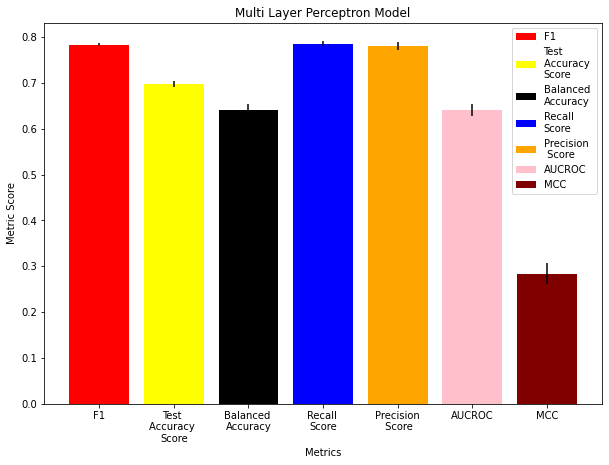

In [115]:
# MLP model

labels = ['F1', 'TestAccuracyScore', 'BalancedAccuracy', 'RecallScore', 'PrecisionScore', 'AUCROC' ]
F1 = F1
f1std = np.std(F1)
F1 = np.mean(F1)
mlpf1 = F1

TestAccuracyScore = TestAccuracyScore
testaccStd = np.std(TestAccuracyScore)
TestAccuracyScore = np.mean(TestAccuracyScore)
mlpAcc = TestAccuracyScore

BalancedAccuracy = BalancedAccuracy
balaccStd = np.std(BalancedAccuracy)
BalancedAccuracy = np.mean(BalancedAccuracy)
mlpBalAcc = BalancedAccuracy

RecallScore = RecallScore
recallaccStd= np.std(RecallScore)
RecallScore = np.mean(RecallScore)
mlprecall = RecallScore

PrecisionScore = PrecisionScore
precScorestd = np.std(PrecisionScore)
PrecisionScore = np.mean(PrecisionScore)
mlpPrecision = PrecisionScore

AUCROC = AUCROC
aucrocstd = np.std(AUCROC)
AUCROC = np.mean(AUCROC)
mlpAUCROC = AUCROC

MCC = MCC
mccStd = np.std(MCC)
MCC = np.mean(MCC)
mlpMCC = MCC

print('f1', F1, 'mcc mean',MCC, 'AUCROC', AUCROC, 'PrecisionScore', PrecisionScore, 'RecallScore', RecallScore, 'BalancedAccuracy', BalancedAccuracy,  'TestAccuracyScore', TestAccuracyScore)


labels = ['F1', 'Test \nAccuracy \nScore', 'Balanced \nAccuracy', 'Recall \nScore', 'Precision\n Score', 'AUCROC' , 'MCC']

allmetrics = [F1, TestAccuracyScore, BalancedAccuracy,RecallScore,PrecisionScore, AUCROC, MCC ]
allmetrics_MLP = allmetrics

std = [f1std , testaccStd, balaccStd, recallaccStd, precScorestd, aucrocstd,mccStd ]
std_MLP = std

print('f1', F1, 'mcc mean',MCC, 'AUCROC', AUCROC, 'PrecisionScore', PrecisionScore, 'RecallScore', RecallScore, 'BalancedAccuracy', BalancedAccuracy,  'TestAccuracyScore', TestAccuracyScore)
ind = np.arange(len(labels))
width = 0.25

fig = plt.subplots(figsize =(10, 7))

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'maroon']
 
#bar plot
barp = plt.bar(labels, height = allmetrics, color = c, yerr = std)
plt.legend(barp, labels, loc='best')
plt.title("Multi Layer Perceptron Model")
plt.xlabel("Metrics")
plt.ylabel("Metric Score")
plt.show()

In [116]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier as RFC
model_instance = RFC
model_params = {'n_estimators': 250}

In [117]:
pred_data = PredictorData(path='/content/tox21_final.csv', get_features=get_fp)
print(pred_data.y)

[1. 1. 1. ... 1. 1. 1.]


In [118]:
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='classifier')

F1,f1name, TestAccuracyScore, testaccname ,BalancedAccuracy,balaccname ,RecallScore, recallname ,PrecisionScore, precscorename , AUCROC , aucrocname, MCC, MCCname = my_predictor.fit_model(pred_data, cv_split='stratified')

f1 0.794715848035182 mcc mean 0.27720791883663304 AUCROC 0.6322819785213962 PrecisionScore 0.7712801555556654 RecallScore 0.8196663741536578 BalancedAccuracy 0.6322819785213962 TestAccuracyScore 0.7055142394527115


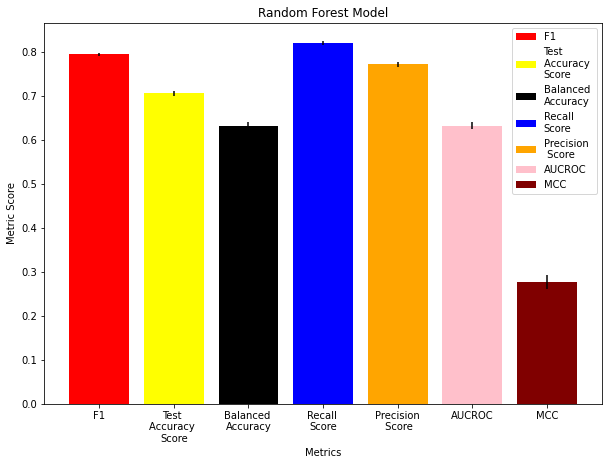

In [119]:
#Random Forest and Reward 1

import matplotlib.pyplot as plt
import numpy as np

labels = ['F1', 'TestAccuracyScore', 'BalancedAccuracy', 'RecallScore', 'PrecisionScore', 'AUCROC' , 'MCC']
F1 = F1
f1std = np.std(F1)
F1 = np.mean(F1)
RFF1 = F1

TestAccuracyScore = TestAccuracyScore
testaccStd = np.std(TestAccuracyScore)
TestAccuracyScore = np.mean(TestAccuracyScore)
RFAcc = TestAccuracyScore

BalancedAccuracy = BalancedAccuracy
balaccStd = np.std(BalancedAccuracy)
BalancedAccuracy = np.mean(BalancedAccuracy)
RFBalAcc = BalancedAccuracy

RecallScore = RecallScore
recallaccStd= np.std(RecallScore)
RecallScore = np.mean(RecallScore)
RFrecall = RecallScore

PrecisionScore = PrecisionScore
precScorestd = np.std(PrecisionScore)
PrecisionScore = np.mean(PrecisionScore)
RFprecision = PrecisionScore

AUCROC = AUCROC
aucrocstd = np.std(AUCROC)
AUCROC = np.mean(AUCROC)
RFaucroc = AUCROC

MCC =  MCC
mccStd = np.std(MCC)
MCC = np.mean(MCC)
rfMCC = MCC

labels = ['F1', 'Test \nAccuracy \nScore', 'Balanced \nAccuracy', 'Recall \nScore', 'Precision\n Score', 'AUCROC' , 'MCC']

allmetrics = [F1, TestAccuracyScore, BalancedAccuracy,RecallScore,PrecisionScore, AUCROC, MCC ]
allmetrics_RFC = allmetrics

std = [f1std , testaccStd, balaccStd, recallaccStd, precScorestd, aucrocstd,mccStd ]
std_RFC = std

print('f1', F1, 'mcc mean',MCC, 'AUCROC', AUCROC, 'PrecisionScore', PrecisionScore, 'RecallScore', RecallScore, 'BalancedAccuracy', BalancedAccuracy,  'TestAccuracyScore', TestAccuracyScore)
ind = np.arange(len(labels))
width = 0.25

fig = plt.subplots(figsize =(10, 7))

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'maroon']
 
#bar plot
barp = plt.bar(labels, height = allmetrics, color = c, yerr = std)
plt.legend(barp, labels, loc='best')
plt.title("Random Forest Model")
plt.xlabel("Metrics")
plt.ylabel("Metric Score")
plt.show()


In [120]:
# SVM

from sklearn.svm import SVC as SVC
model_instance = SVC
model_params = {'cache_size': 100}

In [121]:
pred_data = PredictorData(path='/content/tox21_final.csv', get_features=get_fp)
print(pred_data.y)

[1. 1. 1. ... 1. 1. 1.]


In [122]:
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='classifier')

F1,f1name, TestAccuracyScore, testaccname ,BalancedAccuracy,balaccname ,RecallScore, recallname ,PrecisionScore, precscorename , AUCROC , aucrocname, MCC, MCCname = my_predictor.fit_model(pred_data, cv_split='stratified')

f1 0.8096667296334716 mcc mean 0.2512191650437646 AUCROC 0.605619220406969 PrecisionScore 0.750278128738147 RecallScore 0.8794145446055502 BalancedAccuracy 0.605619220406969 TestAccuracyScore 0.7126282415228002
f1 0.8096667296334716 mcc mean 0.2512191650437646 AUCROC 0.605619220406969 PrecisionScore 0.750278128738147 RecallScore 0.8794145446055502 BalancedAccuracy 0.605619220406969 TestAccuracyScore 0.7126282415228002


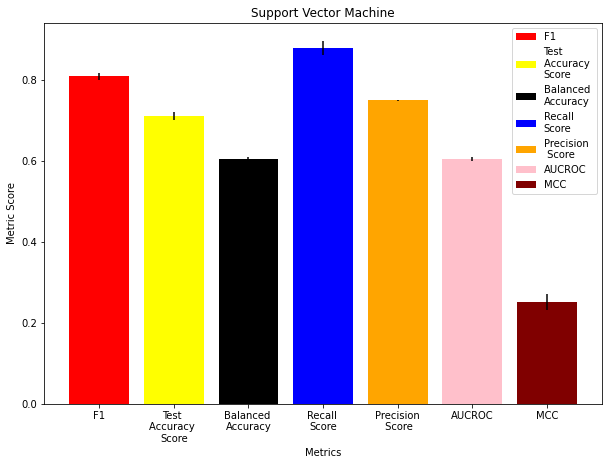

In [123]:
# SVM


labels = ['F1', 'TestAccuracyScore', 'BalancedAccuracy', 'RecallScore', 'PrecisionScore', 'AUCROC' ]
F1 = F1
f1std = np.std(F1)
F1 = np.mean(F1)
svmF1 = F1

TestAccuracyScore = TestAccuracyScore
testaccStd = np.std(TestAccuracyScore)
TestAccuracyScore = np.mean(TestAccuracyScore)
svmAcc = TestAccuracyScore

BalancedAccuracy = BalancedAccuracy
balaccStd = np.std(BalancedAccuracy)
BalancedAccuracy = np.mean(BalancedAccuracy)
svmBalAcc = BalancedAccuracy

RecallScore = RecallScore
recallaccStd= np.std(RecallScore)
RecallScore = np.mean(RecallScore)
svmRecall = RecallScore

PrecisionScore = PrecisionScore
precScorestd = np.std(PrecisionScore)
PrecisionScore = np.mean(PrecisionScore)
svmPrecision = PrecisionScore

AUCROC = AUCROC
aucrocstd = np.std(AUCROC)
AUCROC = np.mean(AUCROC)
svmAucroc = AUCROC

MCC = MCC
mccStd = np.std(MCC)
MCC = np.mean(MCC)
SVMMCC = MCC

print('f1', F1, 'mcc mean',MCC, 'AUCROC', AUCROC, 'PrecisionScore', PrecisionScore, 'RecallScore', RecallScore, 'BalancedAccuracy', BalancedAccuracy,  'TestAccuracyScore', TestAccuracyScore)

labels = ['F1', 'Test \nAccuracy \nScore', 'Balanced \nAccuracy', 'Recall \nScore', 'Precision\n Score', 'AUCROC' , 'MCC']

allmetrics = [F1, TestAccuracyScore, BalancedAccuracy,RecallScore,PrecisionScore, AUCROC, MCC ]
allmetrics_SVM = allmetrics

std = [f1std , testaccStd, balaccStd, recallaccStd, precScorestd, aucrocstd,mccStd ]
std_SVM = std

print('f1', F1, 'mcc mean',MCC, 'AUCROC', AUCROC, 'PrecisionScore', PrecisionScore, 'RecallScore', RecallScore, 'BalancedAccuracy', BalancedAccuracy,  'TestAccuracyScore', TestAccuracyScore)
ind = np.arange(len(labels))
width = 0.25

fig = plt.subplots(figsize =(10, 7))

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'maroon']
 
#bar plot
barp = plt.bar(labels, height = allmetrics, color = c, yerr = std)
plt.legend(barp, labels, loc='best')
plt.title("Support Vector Machine")
plt.xlabel("Metrics")
plt.ylabel("Metric Score")
plt.show()

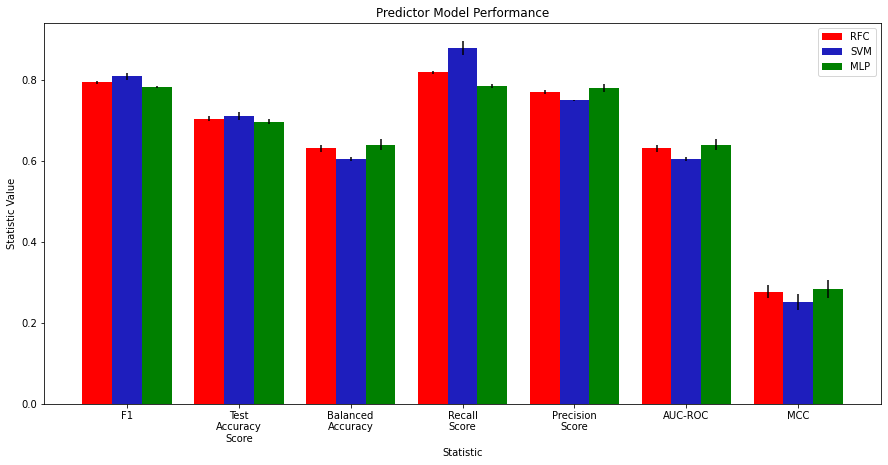

([[0.794715848035182,
   0.7055142394527115,
   0.6322819785213962,
   0.8196663741536578,
   0.7712801555556654,
   0.6322819785213962,
   0.27720791883663304],
  [0.8096667296334716,
   0.7126282415228002,
   0.605619220406969,
   0.8794145446055502,
   0.750278128738147,
   0.605619220406969,
   0.2512191650437646],
  [0.7835687790848113,
   0.6979048335556849,
   0.6412106428414862,
   0.7862925183759892,
   0.780974826769207,
   0.6412106428414862,
   0.2835788705128154]],
 ['F1',
  'Test\nAccuracy\nScore',
  'Balanced\nAccuracy',
  'Recall\nScore',
  'Precision\nScore',
  'AUC-ROC',
  'MCC'])

In [124]:
import numpy as np 
import matplotlib.pyplot as plt 

modelnames = ["RFC", "SVM" , "MLP"]
allmetrics_ALL = [allmetrics_RFC, allmetrics_SVM, allmetrics_MLP] 
std_ALL = [std_RFC , std_SVM , std_MLP]
label_text = ['F1', 'Test\nAccuracy\nScore', 'Balanced\nAccuracy', 'Recall\nScore', 'Precision\nScore', 'AUC-ROC', 'MCC']

colornames = ['red','#1e1ebd','green']

#original_colornames = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'maroon']

X_axis = np.arange(len(allmetrics_RFC))
  
totalwidth = 0.8

nmodels = len(modelnames)  
widthval = totalwidth / nmodels
leftedge = (widthval - totalwidth) / 2
rightedge = 0 - leftedge
centers = np.linspace(leftedge,rightedge,nmodels)

fig = plt.subplots(figsize =(15, 7))

for indexval, itemval in enumerate(modelnames):
    plt.bar(X_axis + centers[indexval], allmetrics_ALL[indexval], widthval, label = itemval, color = colornames[indexval], yerr = std_ALL[indexval])

plt.xticks(X_axis, label_text)
plt.xlabel("Statistic")
plt.ylabel("Statistic Value")
plt.title("Predictor Model Performance")
plt.legend()
plt.show()


# for indexval, itemval in enumerate(modelnames):
#   print(indexval,itemval )
allmetrics_ALL, label_text

We notice between our three predictor models: Random Forest, Support Vector Machine, and MultiLayer Perceptron, the Support Vector Machine performs best in predicting toxicity. We concluded this by focusing on which model has a high Precision score and low Recall Score.


---
Reinforcement Learning
===

---
Here we do the reinforcement learning and compare the generated molecules before and after reinforcement learning to demonstrate the efficacy of this reinforcement learning process.

In [ ]:
"""Import tox21 dataset labels from Therapeutic Data Commons"""

from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Tox21')
label_list

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
import sys
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from tqdm import tqdm

Some of the utility functions defined and used below are adapted from the utility functions used in https://github.com/isayev/ReLeaSE/blob/master/LogP_optimization_demo.ipynb

In [ ]:
# Here we give the generator the chembl molecules to train on how to
# make valid smiles.
# chembl_22_clean_1576904_sorted_std_final.smi is from ReLeaSE

number_of_molecules_used = 1576904 # Number of molecules from the chembl dataset to use, max = 1576904
original_gen_data_path = 'chembl_22_clean_1576904_sorted_std_final.smi' 
gen_data_path = 'condensed.smi'

original_file = open(original_gen_data_path)
original_raw = original_file.read()
original_file.close()
original_split = original_raw.split("\n")

import os
try:
    gendat = open(gen_data_path,'w')
except FileNotFoundError:
    head, tail  = os.path.split(gen_data_path)
    os.mkdir(head)
    gendat = open(gen_data_path,'w')   

for i in range(number_of_molecules_used):
  gendat.write(original_split[i].split("\t")[0] + "\n")
gendat.close()


tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

gen_data = GeneratorData(training_data_path=gen_data_path, 
                         cols_to_read=[-1], keep_header=True, tokens=tokens, use_cuda=use_cuda)

In [ ]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

In [78]:
# Here we either provide the file named as RNN_Training_Checkpoint_Filename as
# a pre-trained checkpoint for the RNN so we don't have to wait for it or if
# if it does not exist then we will train and create a file with that name
RNN_Training_Checkpoint_Filename = 'pre_trained_RNN.pkl'
Train_for_Epochs = 10000

from os.path import exists
file_exists = exists(RNN_Training_Checkpoint_Filename)
print(file_exists)

if file_exists == False:
  losses = my_generator.fit(gen_data, Train_for_Epochs)
  plt.plot(losses)
  my_generator.evaluate(gen_data)
  my_generator.save_model(RNN_Training_Checkpoint_Filename)
else:
  my_generator.load_model(RNN_Training_Checkpoint_Filename)

True


In [79]:
from mordred import Calculator, descriptors
calc = Calculator(descriptors, ignore_3D=True)

df2 = pd.read_csv('/content/tox21_final.csv')
df2.head(10)

SMILES  NR-AR  NR-AR-LBD  \
0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1      0          0   
1                          CCN1C(=O)NC(c2ccccc2)C1=O      0          0   
2  CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...      1          1   
3                    CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C      0          0   
4                          CC(O)(P(=O)(O)O)P(=O)(O)O      0          0   
5               CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C      0          0   
6                                O=S(=O)(Cl)c1ccccc1      0          0   
7             O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1      0          1   
8                      OC[C@H](O)[C@@H](O)[C@H](O)CO      0          0   
9           CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]      1          1   

   NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  SR-ARE  SR-ATAD5  \
0       1             1      1          0              0       1         0   
1       0             0      0          0              0       1         0   
2       1             1      1          1              1       0         1   
3       0             0      0          0              0       1         0   
4       1             0      0          0              0       0         0   
5       0             0      0          0              0       1         0   
6       0             0      0          0              0       0         0   
7       0             1      1          1              1       1         0   
8       0             0      0          0              0       0         0   
9       1             1      1          1              1       0         1   

   SR-HSE  SR-MMP  SR-p53  All  
0       0       0       0    1  
1       1       0       0    1  
2       0       1       1    1  
3       1       0       0    1  
4       0       1       0    1  
5       0       0       0    1  
6       0       0       0    0  
7       1       0       1    1  
8       0       1       0    1  
9       0       1       1    1

tox21_final is the final result of some assumptions we made about tox21, we assumed if a molecule has no value for an assay then it is toxic in that assay and we added an all column that says it is toxic if toxic in any assay

In [80]:
# pred_data = PredictorData(path='/content/split_tox21_with_1_label_data.csv', get_features=get_fp)
pred_data = PredictorData(path='/content/tox21_final.csv', get_features=get_fp)
print(pred_data.y)
# tasks, datasets, transformers = dc.molnet.load_tox21(get_features=get_fp)
# train_dataset, val_dataset, test_dataset = datasets
# X = pred_data.x
# y = pred_data.y

# from sklearn.ensemble import RandomForestClassifier as RFC
# from sklearn.neural_network import MLPClassifier

# # >>> from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)
# my_predictor = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
# clf.predict_proba(X_test[:1])

# array([[0.038..., 0.961...]])
# clf.predict(X_test[:5, :])
# array([1, 0, 1, 0, 1])
# clf.score(X_test, y_test)

# predict(X_test, get_features=get_fp,predictor=my_predictor)

[1. 1. 1. ... 1. 1. 1.]


If you would like to test all three different model performances (SVM, RandomForest, MultiLayerPerceptron) with the generator, please uncomment below accordingly and run the code straight down.

In [ ]:
'''Multi Layer Perceptron (MLP)'''
# from sklearn.neural_network import MLPClassifier
# model_instance = MLPClassifier
# model_params = {}

'Multi Layer Perceptron'

In [ ]:
'''Random Forest Classifier (RFC)'''

# from sklearn.ensemble import RandomForestClassifier as RFC
# model_instance = RFC
# model_params = {'n_estimators': 250}

'Random Forest Classifier'

In [82]:
'''Support Vector Machine (SVM)''' 

from sklearn.svm import SVC as SVC
model_instance = SVC
model_params = {'cache_size': 100}

In [84]:
# Predictor model defined above will be used to as the Predictor model to train the Generator 
# Establish variable for predictor model with appropriate parameters and arguments: classifier, n_estimators, model type
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='classifier')
# Fit model to prediction data
my_predictor.fit_model(pred_data, cv_split='stratified')
# Predict smiles with prediction model, without reward- Policy Gradient enforced
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)


Generating molecules...: 100%|██████████| 10000/10000 [09:18<00:00, 17.92it/s]


[0.6 0.  0.  0.  0.4 1.  1.  0.4 1.  0.  1.  0.  0.6 0.  1.  1.  1.  1.
 1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.6 1.  1.  1.  1.  1.  1.  1.
 1.  1.  0.6 0.2 1.  0.  0.  0.  0.  0.4 0.  1.  1.  0.  0.  0.2 1.  0.2
 1.  1.  1.  0.  1.  1.  1.  0.  1.  0.2 0.  1.  1.  0.2 1.  1.  1.  0.
 1.  0.8 1.  1.  0.  0.6 0.8 1.  1.  1.  1.  1.  0.2 0.  1.  1.  1.  1.
 0.2 1.  1.  0.2 1.  1.  0.6 1.  0.  1.  1.  0.  0.  0.6 0.8 0.  1.  1.
 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.8 1.  0.8 0.2 1.  1.
 1.  1.  0.4 0.6 1.  1.  0.4 1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.8
 1.  0.8 1.  0.  1.  1.  0.8 0.  0.  1.  1.  0.4 1.  0.  0.6 1.  0.  0.
 0.  1.  1.  0.8 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  0.4 1.  1.  1.  0.  0.  0.  1.  1.  1.
 1.  1.  1.  0.2 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  0.8 1.  1.  0.8 1.  1.  1.  1.  1.  0.8 0.  0.6 0.6 1.  1.
 0.8 1.  1.  1.  0.8 0.4 1.  1.  1.  1.  1.  1.  1.  1.  1.  0

In [85]:
# Establish variable for Generator model with appropriate parameters and arguments
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

#load weights for the Generator model
my_generator_max.load_model(RNN_Training_Checkpoint_Filename)

In [86]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 100

In [87]:
# This function is from the LogP optimization demo notebook from ReLeaSE
# Simple moving average displaying how new average value compares to previous iterations
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [88]:
# def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
#     mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
#     if len(nan_smiles) == 1:
#         return invalid_reward
#     return 1/np.exp(prop[0])

---
Reinforcement Model Comparison and Analysis
===

---
Here we have 3 different reward functions, a sigmoid, a step (where reward is only given for perfect non-toxic molecule), and a no reward control (to show what happens if we do no reward).

In order to ensure our model requires a reward function to skew towards non-toxic molecule production, we check our unbiased molecule production with no reward function. Notice the molecules produced vary in ranges of toxicity between 0 and 1. We then move forward to see how implementing a reward function changes our model output.

We implement two different reward functions and see which works best. We hypothesize the sigmoidal function proves to be the most optimal for our reinforcement learning because it provides a sigmoidal curve providing varying reward values for every toxicity prediction. The step reward function works well for allocating a reward for the best toxicity prediction, but provides a scalar reward value for all other predictions, so it treats slight non-toxic molecules as fully toxic as well. Regardless, using a reward function allows the Reinforcement model to learn to create more non-toxic molecules than toxic so the RL model is functionable and the reward function is utilized towards our goal.

In [89]:
# This is the sigmoidal reward function.
def getSigmoidalReward(smiles, predictor, invalid_reward=0.0,get_features=get_fp):
    """
    Allocates reward for a toxicity prediction of the smiles sequence in question.
    Uses a sigmoidal equation to allocate reward with a maximum reward of 3 and minimum reward of 0

    Parameters:
      smiles: sequence of SMILES strings we are analyzing
      predictor: model SMILES prediction gets generated from
      invalid_reward: reward given for invalid SMILES sequence
      get_features: function called to get features for SMILES sequence

    Returns:
      rew: reward value allocated by sigmoidal function for specific SMILES sequence
      
    """
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)

    if len(nan_smiles) == 1:
      return invalid_reward
    else:

      c2 = 3
      c3 = 0.3
      c4 = -3
      c1: float = ((1 - (c2/(1+(c3**c4))))/(1- (1/(1+(c3**c4)))))
      rewlist = []
      rew = c1 + ((c2 - c1)/(1+(c3/prop[0])**c4))
      print("prop length", len(prop), len(rewlist), "rewlist", rewlist)
      return rew
   

In [90]:
# This is the step reward function
def get_reward_tox21(smiles, predictor, invalid_reward=0.0,get_features=get_fp):
    """
    Allocates reward for a toxicity prediction of the smiles sequence in question.
    Uses a step function to allocate a reward of 1 for completely on-toxic molecules,
      and 0 for any toxicity prediction other than 0

    Parameters:
      smiles: sequence of SMILES strings we are analyzing
      predictor: model SMILES prediction gets generated from
      invalid_reward: reward given for invalid SMILES sequence
      get_features: function called to get features for SMILES sequence

    Returns:
      Value: reward value returned by step function for specific SMILES sequence
    
  """
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)

    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] == 0) and (prop[0] != 1.0): # Yes the prop[0] != 1.0 is redundant
        return 11.0
    else:
        return 1.0

In [91]:
# This is the no reward function
def get_reward():
  """
  No reward function to test control case- reinforcement model with no model

  """
  return None

In [92]:
#check prop contents
# mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)

# print(prop)

Here is a plot of our sigmoidal reward function for reference.

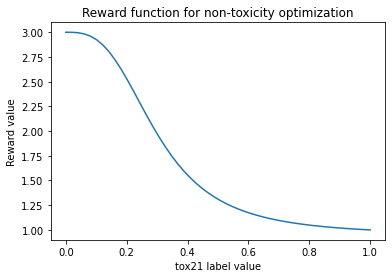

In [110]:
''' Plotting sigmoidal reward function'''

#max reward is 3
c2: int = 3
c3: float = 0.3
c4: int = -3
# enforcing reward = 1 when toxicity = 1
c1: float = ((1 - (c2/(1+(c3**c4))))/(1- (1/(1+(c3**c4)))))
rewlist = []

x = np.linspace(0, 1)
rewlist = []
for i in x:
  rew = c1 + ((c2 - c1)/(1+(c3/i)**c4))
  rewlist.append(rew)
  #print(i, rew)

#plot sigmoidal function
plt.plot(x, rewlist)
plt.plot()
plt.xlabel('tox21 label value')
plt.ylabel('Reward value')
plt.title('Reward function for non-toxicity optimization')
plt.show()

In [94]:
# Please switch out the reward function here to try the three different rewards (Sigmoidal, Step, No Reward)
reward_function = getSigmoidalReward
# Define Reinforcement Learning Model
RL_tox21 = Reinforcement(my_generator_max, my_predictor, reward_function)

In [95]:
#initializing lists for reward and losses in RL model
rewards_max = []
rl_losses_max = []

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:14<03:17, 14.14s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

Policy gradient...:  13%|█▎        | 2/15 [00:37<04:13, 19.51s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop

Policy gradient...:  20%|██        | 3/15 [00:49<03:13, 16.16s/it]

[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:58<02:26, 13.35s/it]

[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [01:08<01:59, 11.98s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [01:14<01:29,  9.97s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [01:24<01:21, 10.18s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [01:33<01:08,  9.73s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [01:41<00:54,  9.03s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [01:48<00:42,  8.41s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [01:55<00:32,  8.13s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [02:03<00:24,  8.19s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rew

Policy gradient...:  87%|████████▋ | 13/15 [02:15<00:18,  9.24s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [02:23<00:08,  8.70s/it]

[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [02:29<00:00,  9.97s/it]


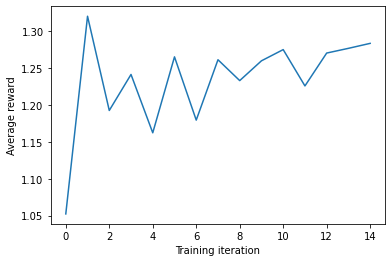

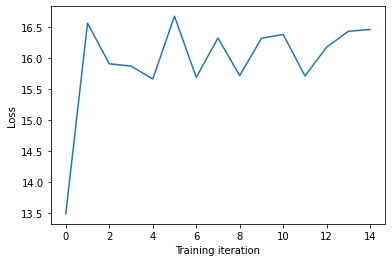

Generating molecules...: 100%|██████████| 200/200 [00:07<00:00, 25.01it/s]


[0.  1.  0.  0.8 0.  0.6 1.  1.  1.  1. ]
Sample trajectories:
CC
CCCOC(=O)C1cc(OC(O)F)C1
CCOCC1CC1=O
CN1CCCCCC2CCCCC(=O)CC1N2
CO


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:05<01:10,  5.03s/it]

[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:09<01:00,  4.69s/it]

[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:14<00:55,  4.64s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:18<00:52,  4.75s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:23<00:48,  4.81s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:25<00:34,  3.87s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:29<00:29,  3.67s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:32<00:25,  3.60s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:37<00:24,  4.07s/it]

[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:41<00:20,  4.00s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:45<00:15,  3.88s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:48<00:10,  3.61s/it]

[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:51<00:07,  3.57s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:55<00:03,  3.56s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:58<00:00,  3.89s/it]


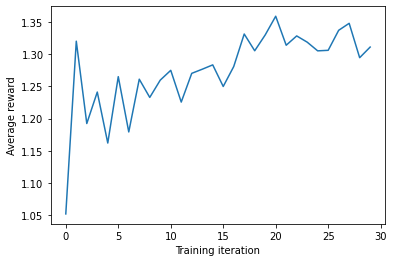

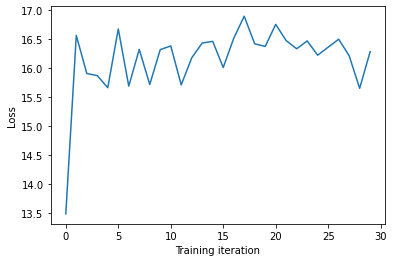

Generating molecules...: 100%|██████████| 200/200 [00:05<00:00, 35.57it/s]


[0.4 0.  1.  0.  1.  0.  1.  1.  0.  0.  0.2 1.  1.  1.  1.  1.  1.  1.
 1.  0.2 1.  0.6 1.  1. ]
Sample trajectories:
C#N
C1COC1
C=C1C(c2cccc(N)c2)N1C
C=O
CCCCCNC(=O)C(C)CCc1cccnc1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:02<00:39,  2.82s/it]

[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:05<00:37,  2.91s/it]

[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:08<00:35,  2.98s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:11<00:29,  2.71s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:13<00:26,  2.69s/it]

[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:17<00:27,  3.06s/it]

[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:20<00:24,  3.09s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:22<00:19,  2.79s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:27<00:19,  3.22s/it]

[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:30<00:16,  3.20s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:32<00:12,  3.02s/it]

[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:36<00:09,  3.15s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:38<00:05,  2.93s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:40<00:02,  2.53s/it]

[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:42<00:00,  2.85s/it]


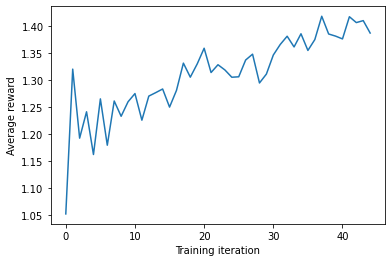

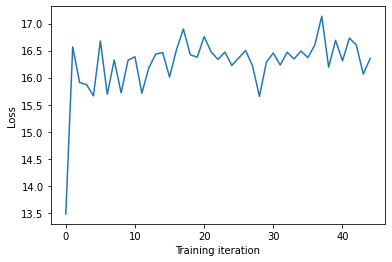

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 41.66it/s]


[0.  0.  0.  0.  1.  0.  1.  0.6 0.6 1.  0.  1.  0.6 1.  1.  1.  1.  1.
 0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
Sample trajectories:
CC1C(=O)C1C
CC1CC1
CC1CCCCCC1
CC1CCCCCOC1
CC1CCN(C)C1CCCc1ccccc1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:25,  1.79s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:03<00:26,  2.02s/it]

[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:06<00:29,  2.48s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:09<00:26,  2.38s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:11<00:23,  2.37s/it]

[]
[0.4]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:13<00:18,  2.07s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:15<00:16,  2.10s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:17<00:16,  2.30s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:19<00:13,  2.20s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:21<00:10,  2.08s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:24<00:08,  2.14s/it]

[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:26<00:06,  2.16s/it]

[]
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:27<00:03,  1.99s/it]

[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:29<00:02,  2.02s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


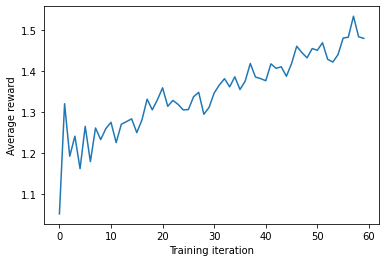

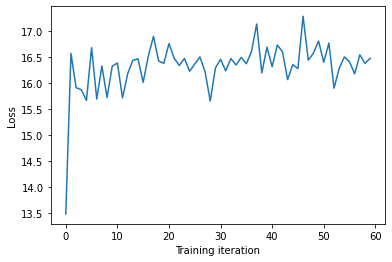

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 42.41it/s]


[0.6 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.2 0.  0.6 1.  0.6 0.  1.
 0.  0.  0.  0.  1.  0.4 1.  0.6 0.  0.  0.  0.  1.  0.4 0.2 1.  1.  1.
 0.4 1.  1.  1.  1.  0.  1.  1.  1.  1.  1. ]
Sample trajectories:
C
C=COC1CCCC1CCC
C=NC(=O)O
CC1CCC(C)C1
CC1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.42s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:03<00:20,  1.58s/it]

[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:04<00:19,  1.63s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.4]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:08<00:17,  1.75s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:10<00:16,  1.81s/it]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:12<00:14,  1.79s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:13<00:12,  1.80s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:15<00:10,  1.81s/it]

[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:17<00:08,  1.74s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:19<00:06,  1.72s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:20<00:05,  1.74s/it]

[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:22<00:03,  1.68s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:24<00:01,  1.77s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]


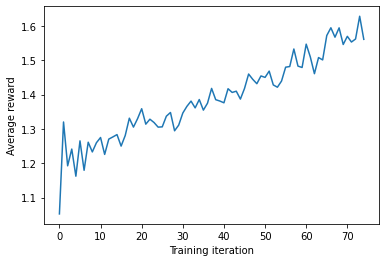

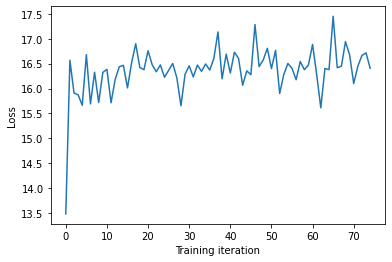

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 52.18it/s]


[0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.6 0.6 1.
 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.4 1.  1.  0.8 1.
 1.  1.  1.  0.8 0.6 0.  0.8 0.  0.  0.2 1. ]
Sample trajectories:
C1COC1
CC(O)C1CC1
CC1CC1CCC1COCCCO1
CC1CCCC1
CC1CCCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:24,  1.74s/it]

[1.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:03<00:23,  1.79s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:05<00:22,  1.89s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:07<00:19,  1.79s/it]

[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:08<00:17,  1.73s/it]

[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:10<00:14,  1.60s/it]

[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:11<00:12,  1.56s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:13<00:11,  1.70s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:15<00:09,  1.62s/it]

[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:16<00:07,  1.57s/it]

[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:18<00:06,  1.55s/it]

[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:19<00:04,  1.46s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:20<00:03,  1.51s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:22<00:01,  1.54s/it]

[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


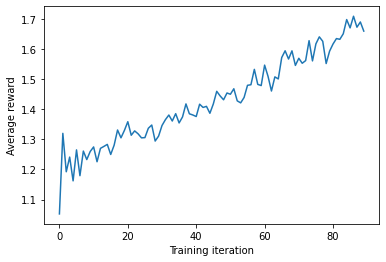

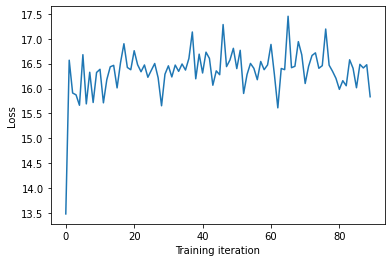

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 58.12it/s]


[0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.
 0.  0.8 1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.
 1.  1.  1.  0.8 0.6 1.  0.  0.  0.  0.2 1. ]
Sample trajectories:
CC1CC1
CC1CCC1
CC1CCCC1
CC1CCCC1O
CC1CCCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:23,  1.66s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:03<00:21,  1.64s/it]

[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:04<00:18,  1.56s/it]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:06<00:16,  1.47s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:07<00:14,  1.49s/it]

[0.2]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:08<00:13,  1.45s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:10<00:12,  1.61s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:12<00:10,  1.56s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:13<00:09,  1.55s/it]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:15<00:07,  1.59s/it]

[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:17<00:06,  1.55s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:18<00:04,  1.46s/it]

[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:19<00:02,  1.41s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:21<00:01,  1.43s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:23<00:00,  1.53s/it]


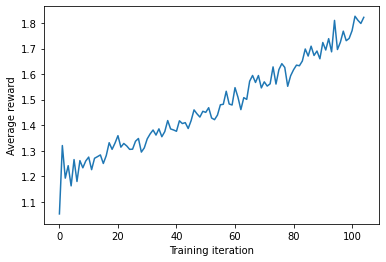

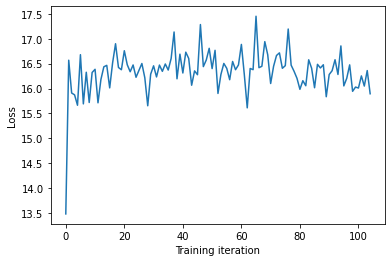

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 54.03it/s]


[0.  0.  0.  0.6 1.  1.  0.  0.  1.  0.6 0.  1.  0.  0.  0.6 0.6 0.  0.8
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.6 0.2 1.  0.6 0.  0.4 1.  0.  0.
 0.  0.6 0.  0.2 0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.6 1.  1.
 0.  0.  1. ]
Sample trajectories:
BOC1CCCCC1
C1CC1
C1CCoC1
C=CCC
C=CCC1CCC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.42s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.34s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.36s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:05<00:16,  1.48s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.27s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.33s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.42s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.45s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:07,  1.45s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.48s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.52s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:03,  1.53s/it]

[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:20<00:01,  1.54s/it]

[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


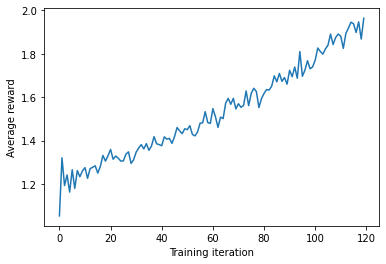

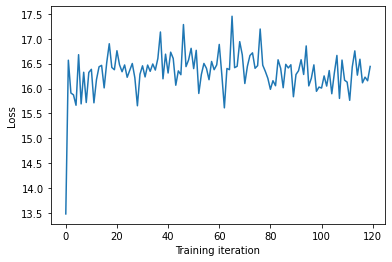

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 56.34it/s]


[0.6 0.  0.2 1.  0.  1.  1.  0.4 0.  0.2 0.  0.  0.  0.  0.  1.  0.  1.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.6 0.
 0.  1.  0.4 0.6 1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
 1.  0.8 0.8 1.  0.6 0.6 0.  0.  1. ]
Sample trajectories:
C
C1CCC2CCC2C1
C1CCCCC1
C=C1CC1C1CNCC1CCCC
CC(C)CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:21,  1.51s/it]

[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:19,  1.49s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:04<00:17,  1.44s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.44s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:07<00:13,  1.36s/it]

[]
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.37s/it]

[]
[]
[]
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.36s/it]

[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.38s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.36s/it]

[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.40s/it]

[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.39s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.39s/it]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.40s/it]

[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.39s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


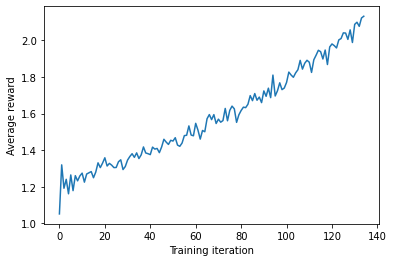

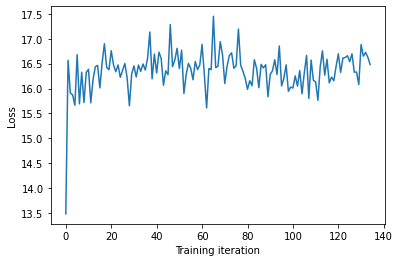

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 55.56it/s]


[0.2 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.8 0.  1.  0.  0.  0.
 0.  0.  0.  1.  1.  0.  0.  1.  1.  0.6 1.  1.  0.2 0.  0.  0.  0.  0.
 0.  0.  1.  0.6 0.6 0.6 0.  0.  0.  0.  0.  0.  0.  1. ]
Sample trajectories:
C1CCCCC1
CC
CC(O)c1CC1
CC1=CCC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.26s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.30s/it]

[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.38s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.35s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.43s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:09<00:11,  1.43s/it]

[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.36s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.34s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.29s/it]

[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.38s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.39s/it]

[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.34s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:18<00:01,  1.35s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


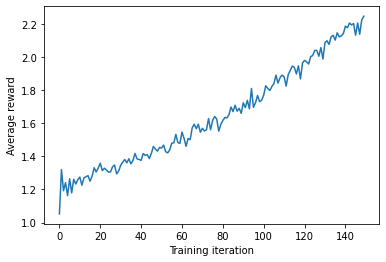

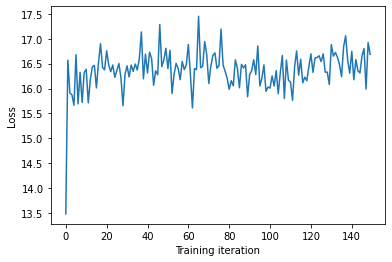

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 58.73it/s]


[0.2 0.  0.  0.  1.  0.  0.  0.2 1.  0.  0.  0.  0.  0.  0.  0.  1.  1.
 0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.
 0.  0.  0.2 1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.8 0.6 1.  1.  0.8
 1.  0.4 0.  1.  1.  1. ]
Sample trajectories:
C1CCCCC1
CC
CC(C)C1CCC1
CC1CC(C)C1
CC1CC(C)n1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.39s/it]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.33s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:15,  1.31s/it]

[0.8]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.31s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.28s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.29s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:08,  1.26s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.26s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.23s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.29s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:15<00:03,  1.27s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:16<00:02,  1.30s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:17<00:01,  1.26s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


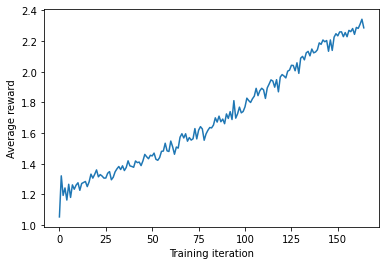

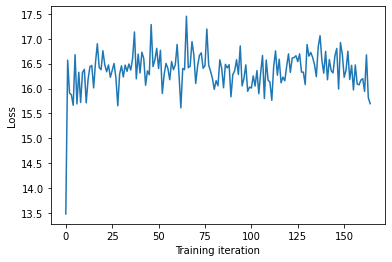

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 61.84it/s]


[0.2 0.  0.2 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.2 0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  1.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.4 0.6 0.  1.  1.  1.  0.  0.
 0.  0.  0.  1. ]
Sample trajectories:
C1CC(C2CC2)C1
C1CCC1
C1CCCC1
CC1CC1
CC1CC=CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.39s/it]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:18,  1.43s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.37s/it]

[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.38s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:07<00:14,  1.42s/it]

[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:08<00:13,  1.49s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:09<00:11,  1.39s/it]

[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.39s/it]

[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.39s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.35s/it]

[]
[0.4]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.34s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.37s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.39s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.32s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


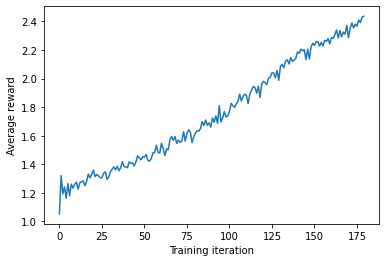

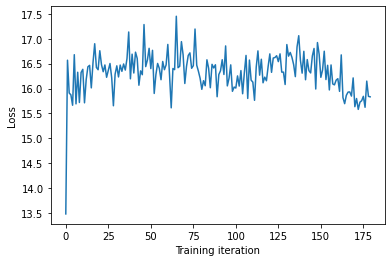

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 64.19it/s]


[0.  0.  0.2 0.2 0.4 0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
 0.  0.2 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.4 1.  1.  0.
 0.  0.2 0.  0.  0.  0.  1.  1.  1.  0.  0.8 0.  1.  0.  1. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1
CC(=O)NC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.09s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.25s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.22s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:13,  1.22s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.23s/it]

[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.23s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.22s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.21s/it]

[]
[0.2]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.19s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:05,  1.19s/it]

[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:04,  1.17s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.14s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.14s/it]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.12s/it]

[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


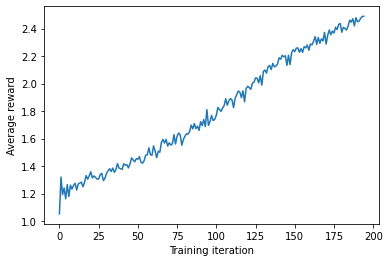

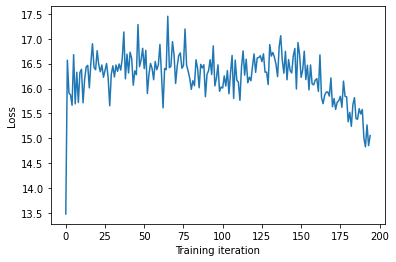

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 64.93it/s]


[0.  0.  0.  0.  0.2 0.2 0.8 0.  0.  0.  1.  0.  0.2 0.  0.  0.  0.  0.2
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.6 1.  0.  0.  0.
 0.  0.  0.  0.  0.  0.6 1.  0.8 1.  1.  1.  1.  0.6 0.  0.  0.  1.  1. ]
Sample trajectories:
C1CC(CC2CCC2)C1
C1CC1
C1CC1CCC1CO1
C1CCC1
C1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:20,  1.47s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.28s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.23s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:13,  1.19s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:06<00:11,  1.18s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.25s/it]

[1.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.24s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.21s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.20s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:05,  1.16s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:04,  1.15s/it]

[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.14s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.13s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.12s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


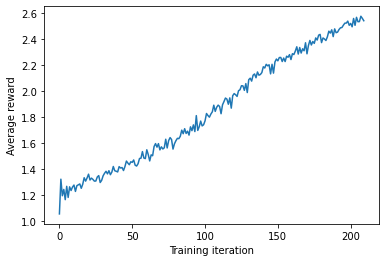

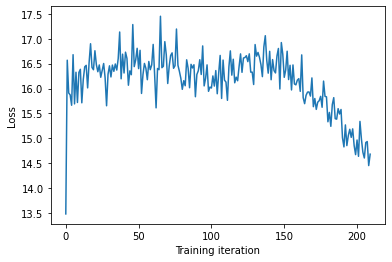

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 64.88it/s]


[1.  0.  0.  0.  0.2 0.2 0.8 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.8 0.6 0.  0.  0.  0.8
 0.  1.  0.6 0.2 0.8 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1. ]
Sample trajectories:
C1=CCCCCC1
C1CC(CC2CCC2)C1
C1CCC(CC2CC2)C1
C1CCC1
C1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.15s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.12s/it]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.10s/it]

[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.10s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.16s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:09,  1.13s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.09s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.12s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.12s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.13s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.12s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.12s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


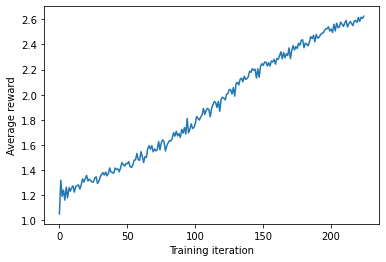

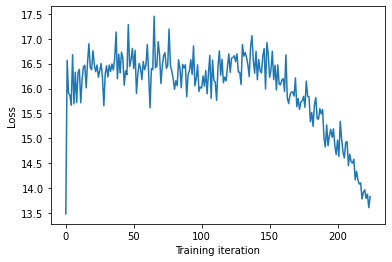

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 65.46it/s]


[0.  0.  0.  0.2 0.2 0.  0.  0.2 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
 0.  1.  0.  1.  0.8 0.6 0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CC1CCC1CC1
C1CCC1
C1CCCC1
C1CCCCCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.4]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.09s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.04s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.06s/it]

[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.09s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.10s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.11s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.09s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.05s/it]

[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.03s/it]

[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.02s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.01s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


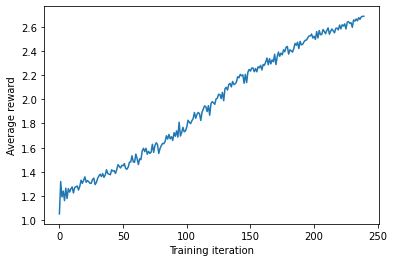

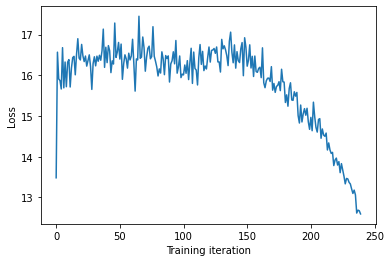

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 73.77it/s]


[0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.
 0.  0.  0.2 0.4 0.  0.  0.  0.  0.  0.8 1.  1.  0.  0.  0.  0.  0.  0.
 1. ]
Sample trajectories:
C1CC1
C1CCC1
C1CO1
CBC1CC1
CC


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.06s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.06s/it]

[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.05s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.06s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.07s/it]

[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.07s/it]

[]
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.07s/it]


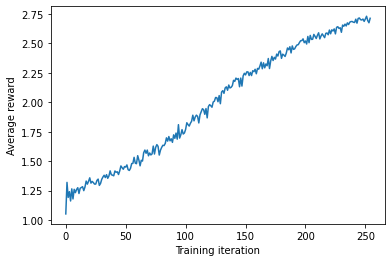

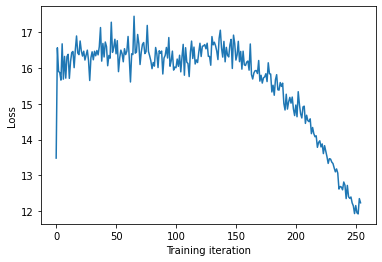

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 72.47it/s]


[0.  0.  0.2 0.4 0.  0.  0.  0.  0.  0.  0.8 0.6 1.  0.4 0.  0.  0.  0.
 0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  1.  0.8 0.2 1.  1.  1.  1.  0.6
 0.  0.  0.  1.  0.2]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1C[IH]C1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.07s/it]

[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.10s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.05s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.4]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.01s/it]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.01s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.00s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:06,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:05,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:04,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.02s/it]

[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.06s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


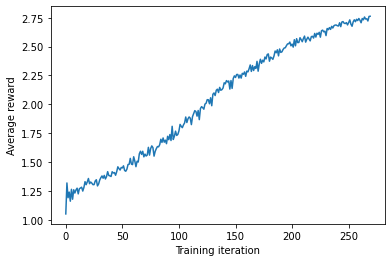

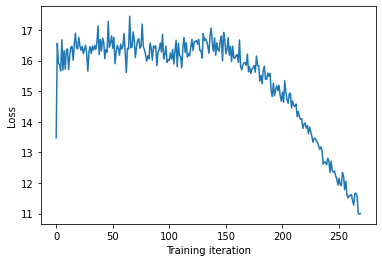

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 73.91it/s]


[0.  0.  0.  0.6 0.4 0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.6 1.  0.  1.  0.8 0.8 1.  0.6 0.  0.  0.
 1.  0.  0.  0.  1. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCOC1
C1CN1
C=C1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.11s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.04s/it]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.03s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


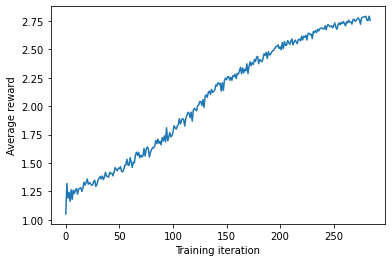

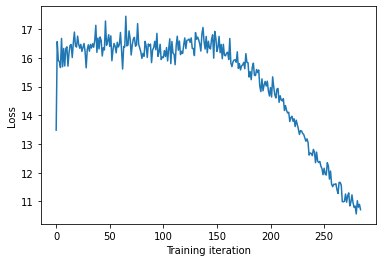

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 69.69it/s]


[0.2 0.  0.  0.8 1.  0.  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
Sample trajectories:
BC1CCC1
C1CC1
C1CCC1
C=C1CC1C
CC1C=CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.01s/it]

[0.6]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:01,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[]
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.03s/it]

[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


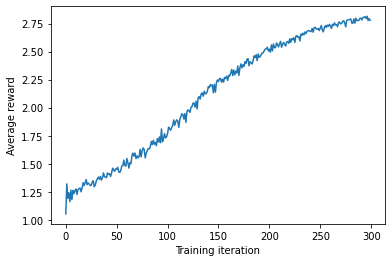

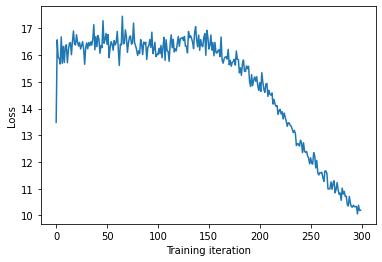

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 71.16it/s]


[0.4 0.  0.  0.2 0.2 0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.6 1.  0.  0.  0.  0.  0.  1.
 0.8 1.  1.  1.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1=CC1
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.09s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.06s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.01s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:01,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:00,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


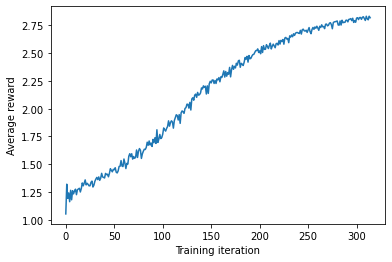

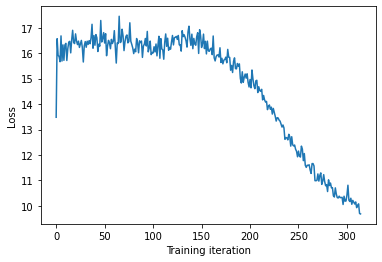

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 75.23it/s]


[0.  0.  0.2 0.2 0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  1.  0.4 1.  0.  0.  1.  0.6 0.6 0.  0.  0.
 0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCCCCC1
C=C1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.01s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


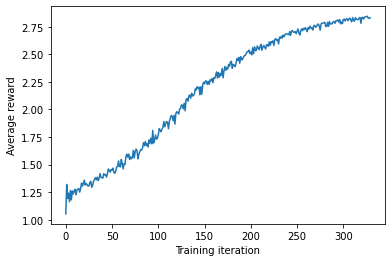

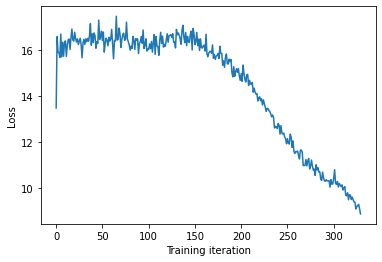

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.27it/s]


[0.  0.  0.6 0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.4
 0.8 0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CnC1
CC1C=C1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.03it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


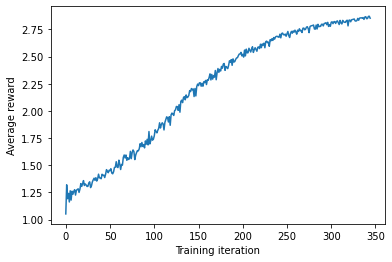

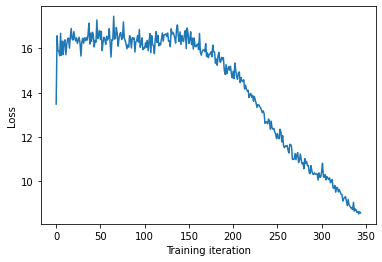

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.38it/s]


[0.6 0.  0.  0.6 0.  1.  0.  0.  0.  0.  0.  0.  0.6 0.  0.2 0.8 0.  0.
 0.  0.8 0.4 1.  0.  0.  0.6 1.  0.8 0.8 1.  0.  0.  0.  0. ]
Sample trajectories:
C
C1CC1
C1CCC1
C1CNC1
C1CO1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.01s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:10,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:09,  1.00s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.03it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:03,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


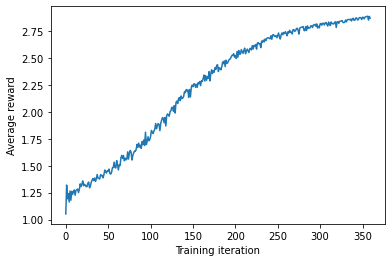

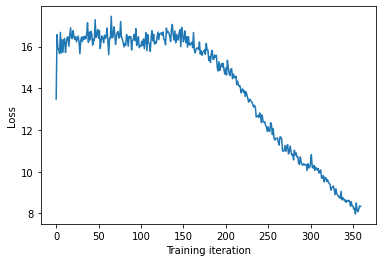

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.48it/s]


[0.  0.  0.8 0.6 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.2 1.  0.2 0.8 0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C=C1CC1C
CC1=CC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[1.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.05s/it]

[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:07,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.01s/it]

[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


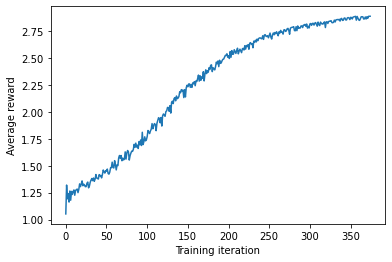

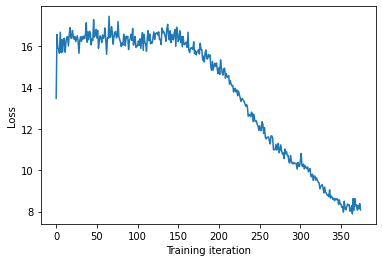

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 72.68it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.8
 0.  0.  0.6 0.  0.8 1.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CC1CCC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.02it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.00it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.00it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:02,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:01,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


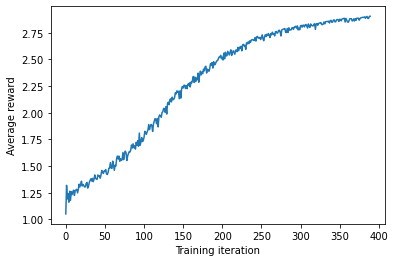

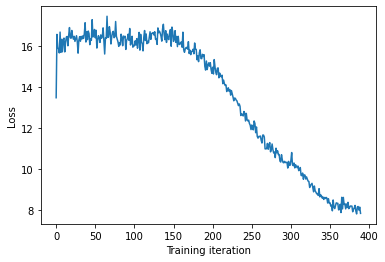

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.78it/s]


[0.  0.  0.2 0.8 0.6 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCNC1
CC1=CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.02it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.00it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:06,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


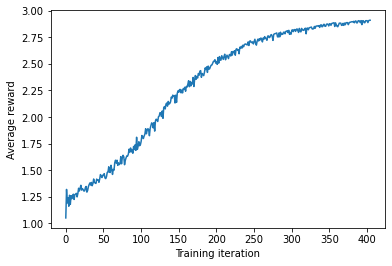

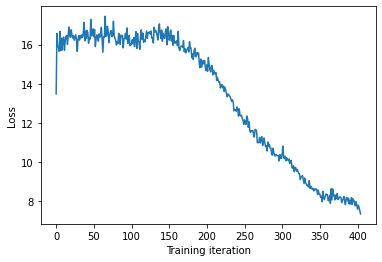

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.05it/s]


[0.6 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.8 1.  0.  0.
 0.  0. ]
Sample trajectories:
C
C1CC1
C1CCC1
CC1C=CC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


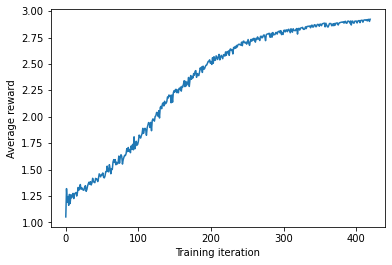

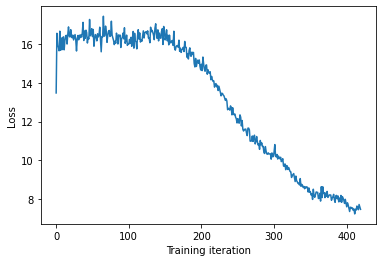

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 77.69it/s]


[0.  0.  0.2 0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.
 0.2 0.8 1.  0.6 0.  0.  0.  0.  0.8]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCOC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.03it/s]

[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:01,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


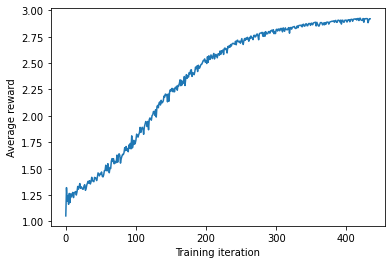

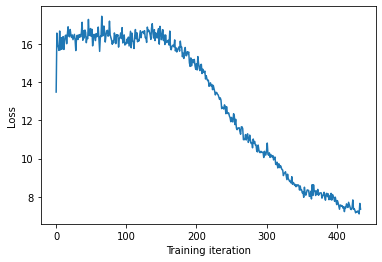

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.31it/s]


[0.  0.  0.  0.4 0.  0.  1.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.
 0.  0.  1.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCOC1
C=C1CC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.03it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


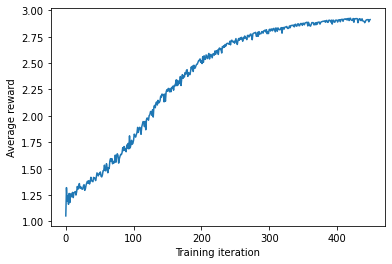

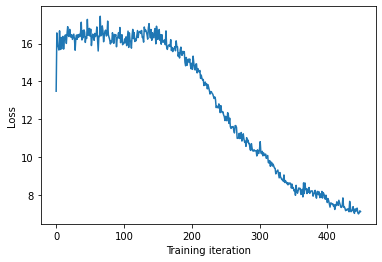

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.82it/s]


[1.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.
 0.2 0.8 0.  0.  0.4 0. ]
Sample trajectories:
C1=CCC1
C1CC1
C1CCC1
CC1=CC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


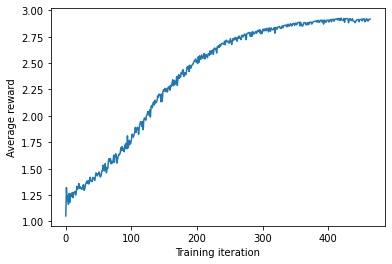

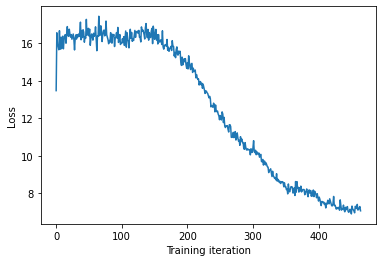

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 69.91it/s]


[0.  0.  0.2 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCNCC1
CB1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.13s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.07s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:09,  1.00it/s]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:08,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:07,  1.01it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:06,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:03,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:02,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:01,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:00,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


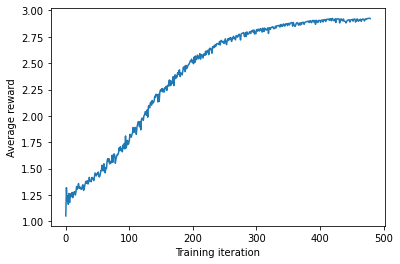

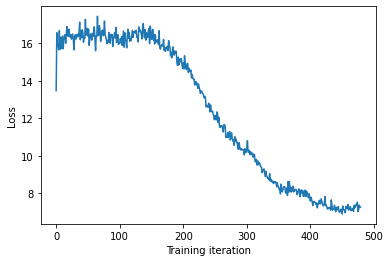

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 72.49it/s]


[0.  0.  0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  1.  0.  0.  1.  0.  0.8 0.  0.  0.  0.  0.  1. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1
C1CCCCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.04it/s]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


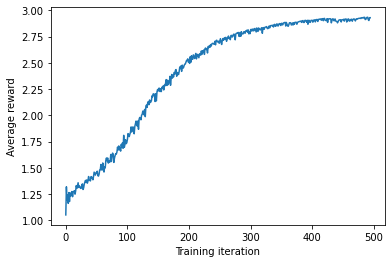

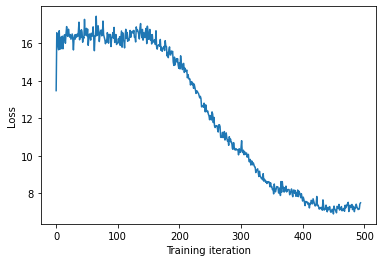

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 71.05it/s]


[0.  0.  0.2 0.4 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  1.  0.4 0.8 0.8 0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCCC1
C=C1CCC1
CC1CC(C)C1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.19s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:15,  1.16s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.11s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.03s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


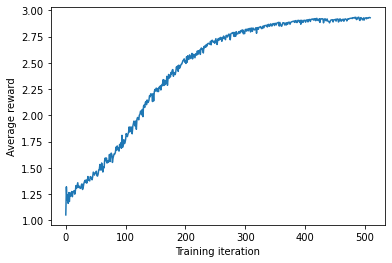

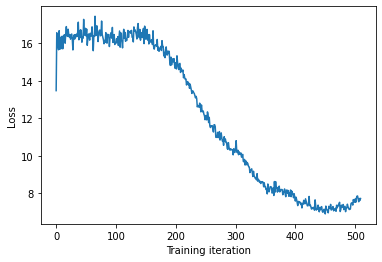

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 69.83it/s]


[0.  0.  0.2 0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1
C1CCCCCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.04s/it]

[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.09s/it]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.07s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


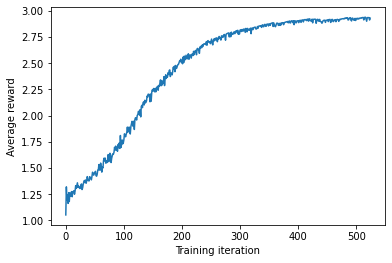

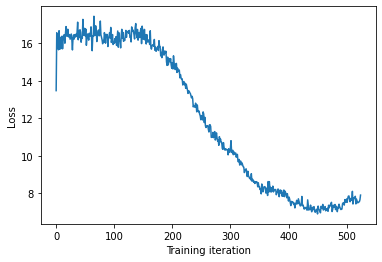

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 71.87it/s]


[1.  0.  0.  0.2 0.2 0.  1.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  1.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.8 1.  0.  0.  0.  0. ]
Sample trajectories:
C1=CCC1
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.01s/it]

[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.02it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.00it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.00it/s]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


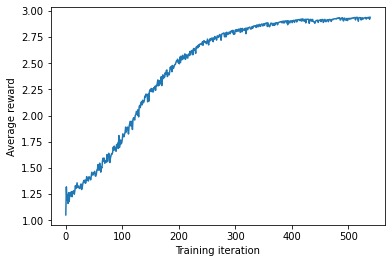

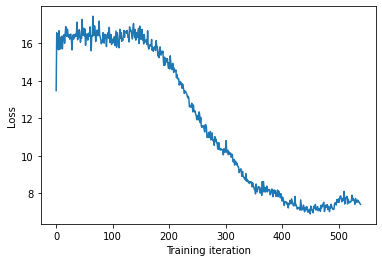

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 72.42it/s]


[0.  0.  0.2 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.4 0.  0.  0.6
 1.  0.6 0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.02s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


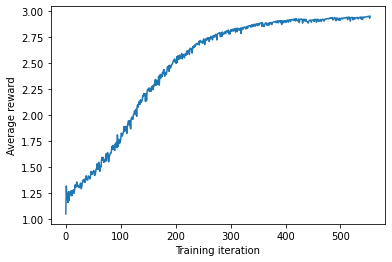

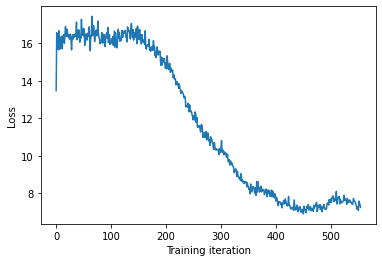

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 75.76it/s]


[0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.6 0.
 0.  0.  0.8 1.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.02it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


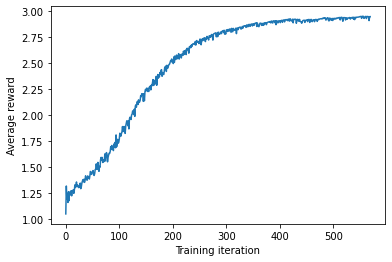

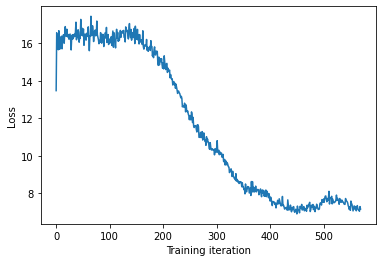

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 70.18it/s]


[0.  0.  0.2 0.2 1.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.6 1.  0.  0.  0.  0.  0.
 0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1
CC1C=CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:11,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


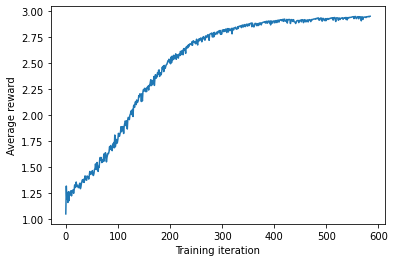

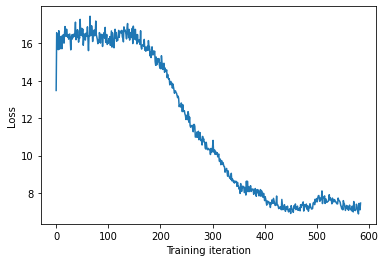

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 75.86it/s]


[0.  0.  0.2 0.2 0.6 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.8
 1.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1
C1CN1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.01s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:08,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.02it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


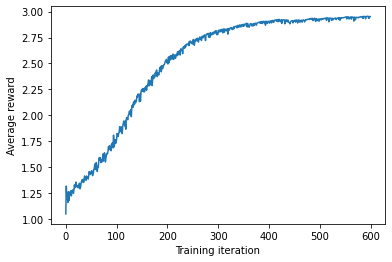

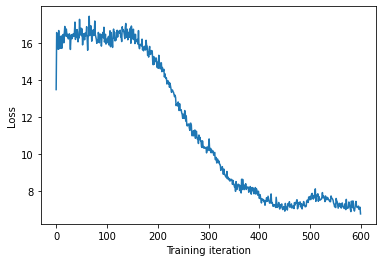

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.42it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.2 0.  0.  0.
 1. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.08it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.05it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


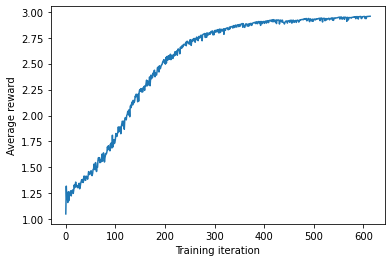

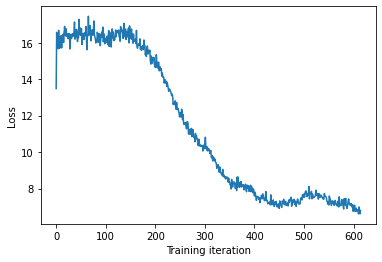

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.36it/s]


[0.  0.  0.2 0.  0.6 0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
 0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCOC1
CC1=CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.01s/it]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


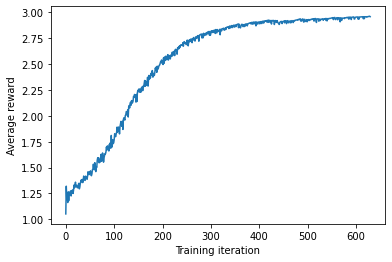

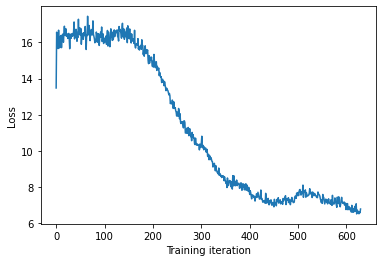

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.84it/s]


[0.  0.  0.6 0.4 0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.8
 0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CNC1
C1CSC1
CC1=CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


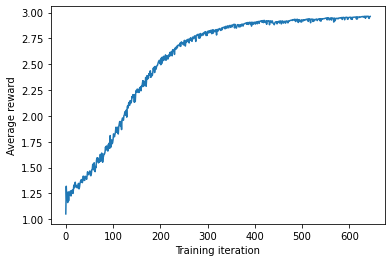

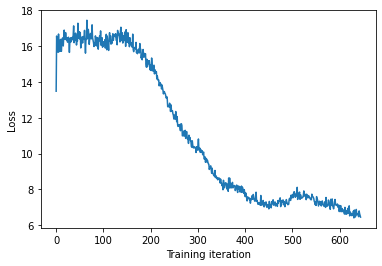

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.57it/s]


[0.  0.  0.2 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C=CCC1CC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


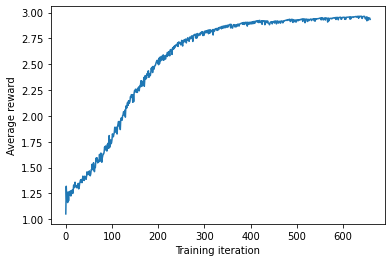

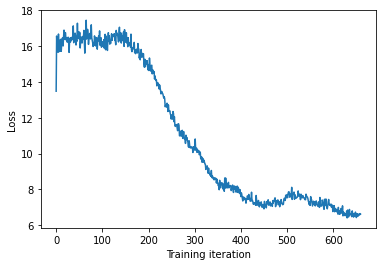

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.30it/s]


[0.  0.  0.2 0.4 0.  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.6 0.
 0.  0.4 0.  0.  0.  0.8 0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C=C1CCC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


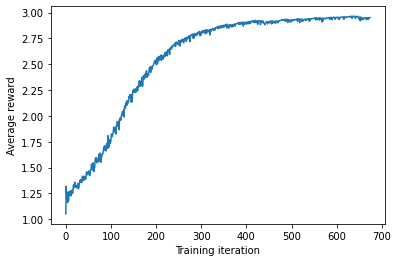

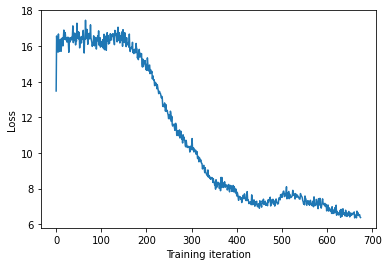

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 79.42it/s]


[0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  1.  0.
 0.  0.2 0.8 1. ]
Sample trajectories:
BC1CC1
C1CC1
C1CCC1
C1CCCC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


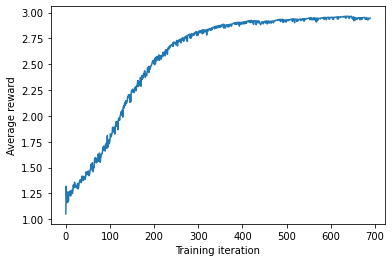

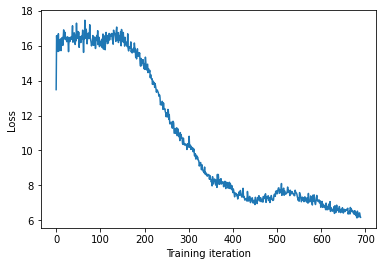

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 75.51it/s]


[0.  0.  0.2 0.2 0.2 0.4 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  1. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCCCC1
C1CCCc1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


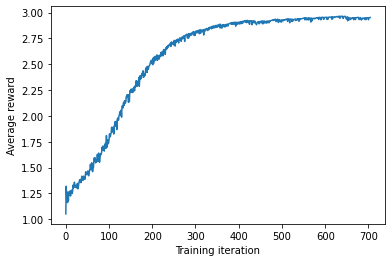

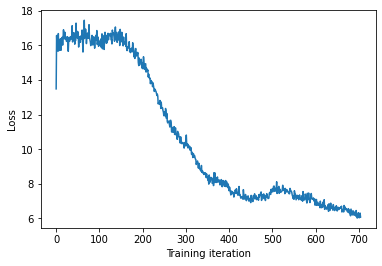

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 76.38it/s]


[0.  0.  0.2 0.6 0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.6
 0.4 0.  1.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CNC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:12,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


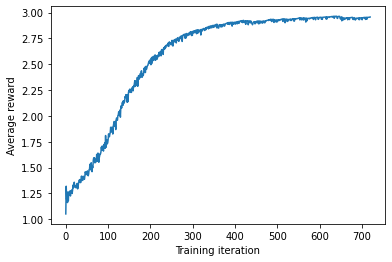

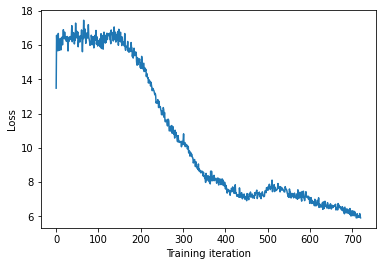

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.23it/s]


[0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


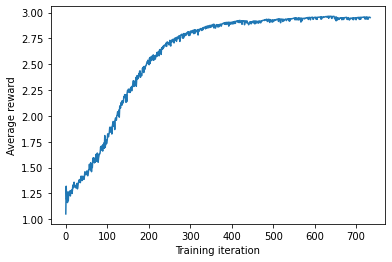

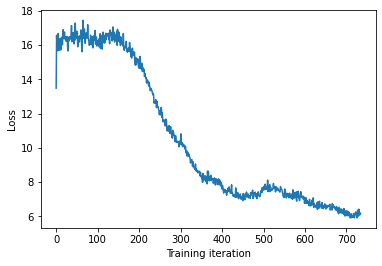

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.09it/s]


[0.  0.  0.2 0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.4 0.  0.  0.8 0.
 0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1CC(C)C1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


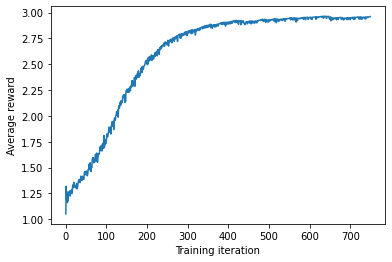

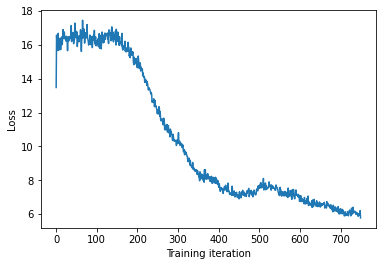

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 74.44it/s]


[0.  0.  0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0.
 0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1CCNC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


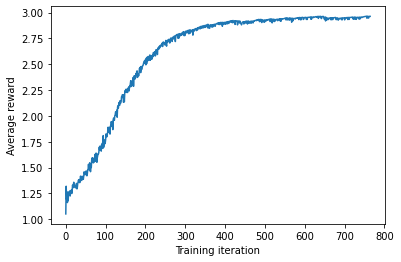

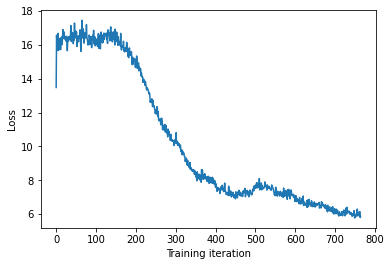

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.34it/s]


[0.  0.  0.4 0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.8 0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C=C1CC1
CC1C=C1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


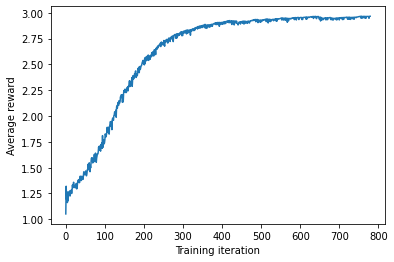

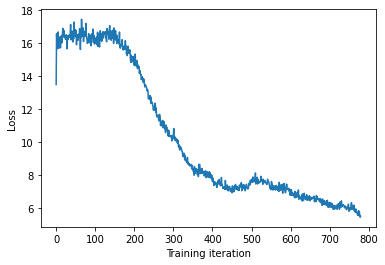

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.80it/s]


[0.  0.  0.2 0.6 0.6 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1Cn1
CC1=CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


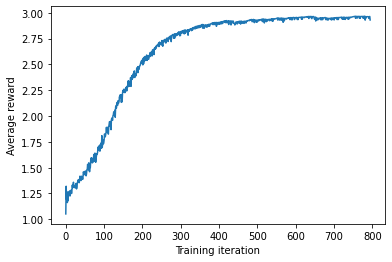

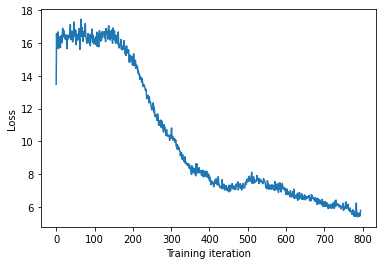

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 77.49it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:12,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


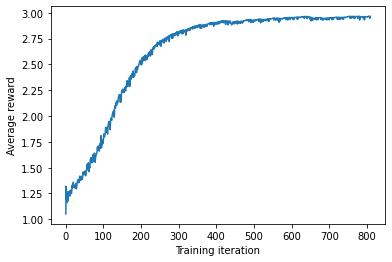

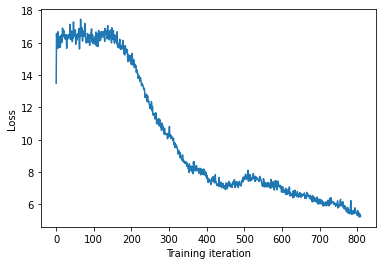

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 74.03it/s]


[0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.2 1.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CC1CCC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


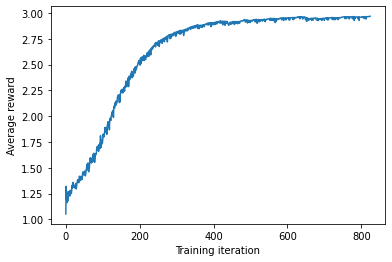

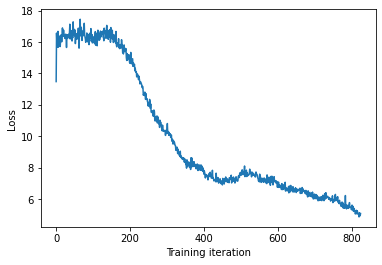

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 77.41it/s]


[0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CO1
C1Cs1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


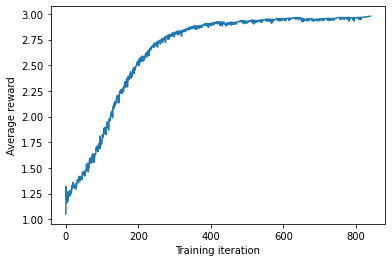

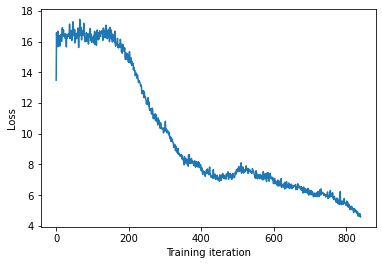

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 77.95it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1COC1
CC1CC1
CC1CC1=O


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


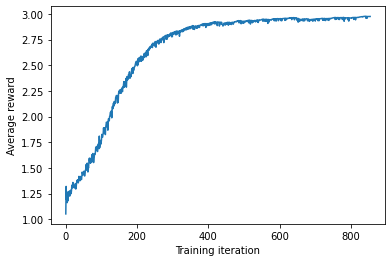

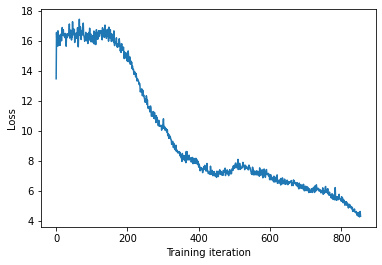

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 79.13it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.8 0.  0.  0. ]
Sample trajectories:
BC1CC1
C1CC1
C1CCC1
CC1CC1
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.08it/s]

[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


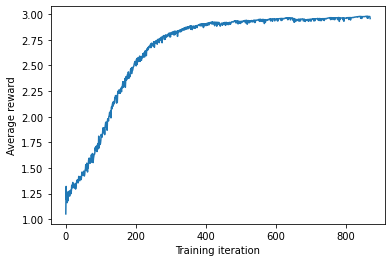

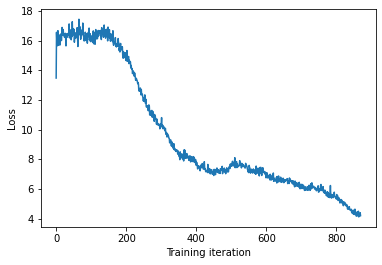

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.13it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 1.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CO1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:11,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


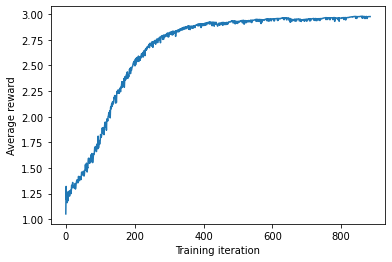

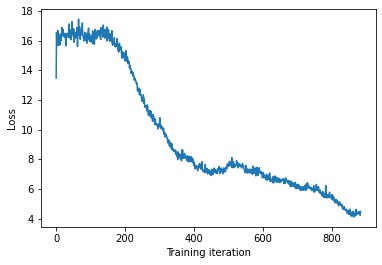

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 79.27it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  1. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CC1CCO


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


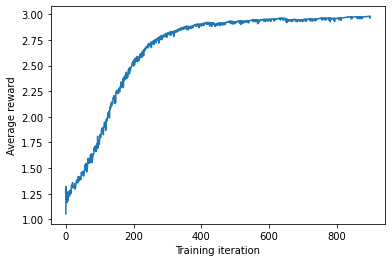

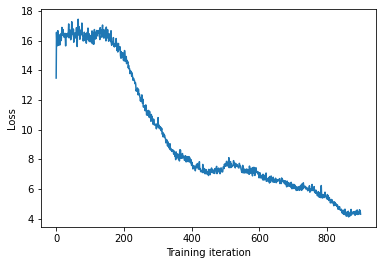

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 77.36it/s]


[0.6 0.  0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C
C1CC1
C1CCC1
C1CsC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


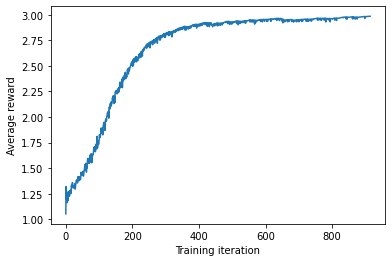

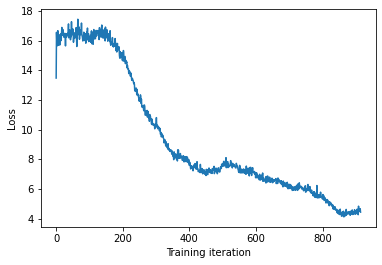

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.87it/s]


[0.  0.  0.2 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


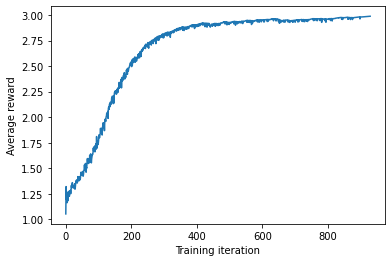

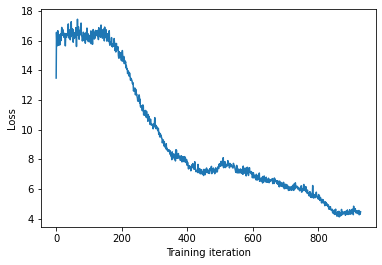

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 79.84it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CC1CCC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:12,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.01s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


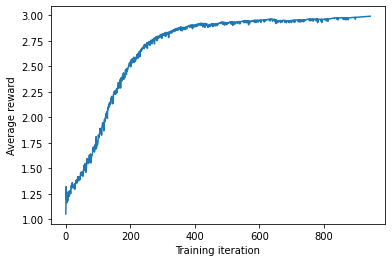

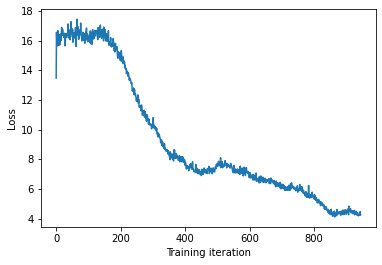

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 79.38it/s]


[0.  0.  0.2 0.6 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1=CC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:18,  1.32s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.12s/it]

[1.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:09,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]

[0.]
prop length 1 0 rewlist []


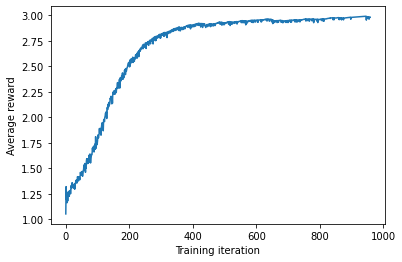

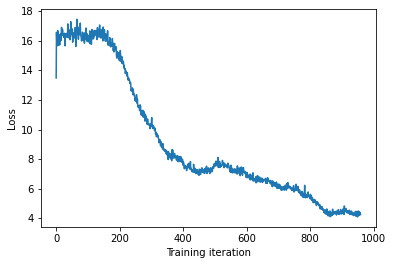

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.51it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


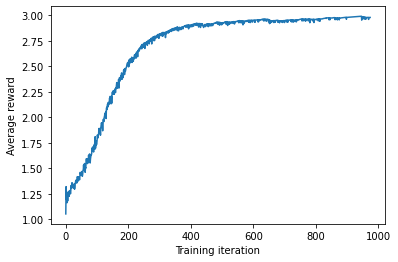

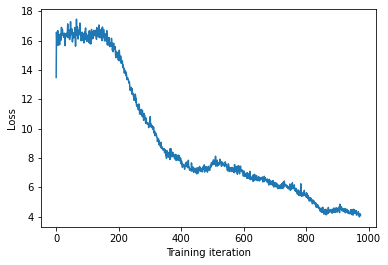

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.95it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.8 0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CC1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.05it/s]

[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


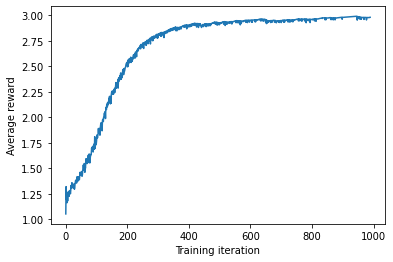

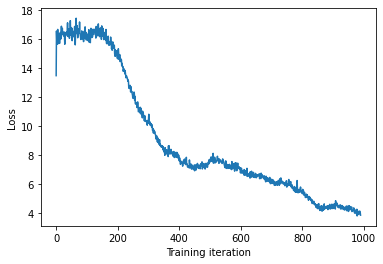

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.77it/s]


[0.  0.  0.2 0.  0.  1.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1CC1
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


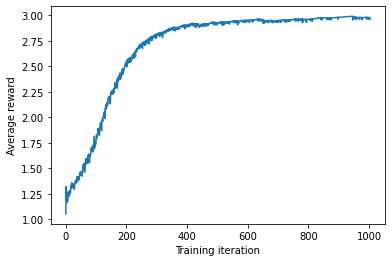

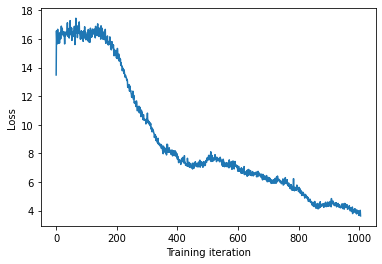

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.79it/s]


[0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1Cn1
CC1CC1
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


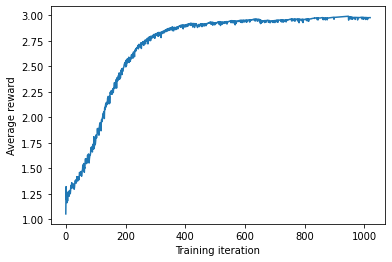

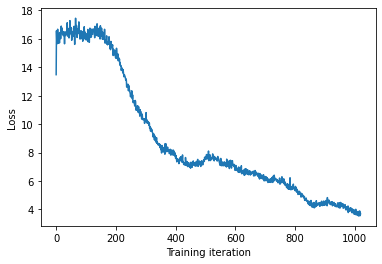

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 79.32it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.6 0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


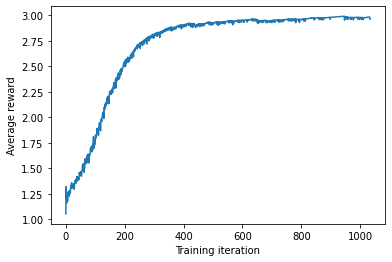

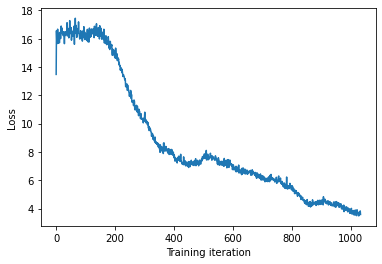

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.24it/s]


[0.6 0.  0.  0.2 0.  1.  0.  0.  0.  0.  0.4 0.  0.8 0.  0.  1. ]
Sample trajectories:
C
C1CC1
C1CCC1
C1CCCC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


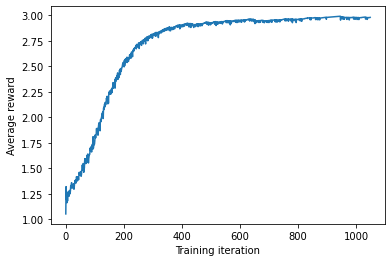

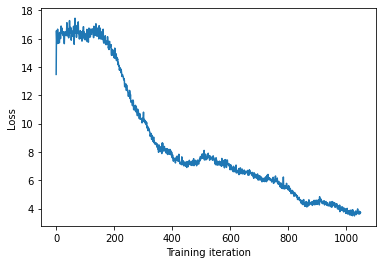

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.39it/s]


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


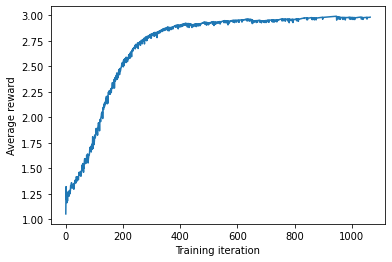

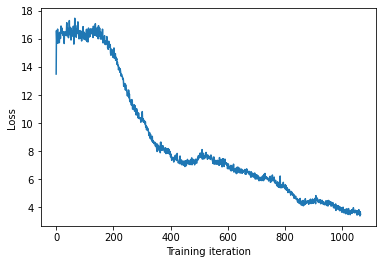

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.49it/s]


[0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.8 0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


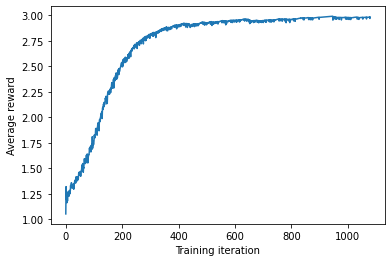

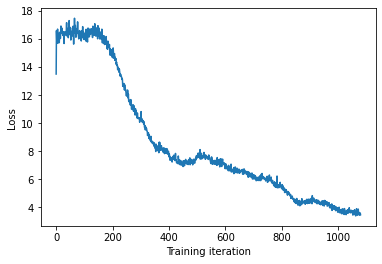

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.13it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CC1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


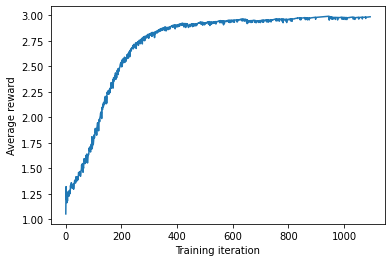

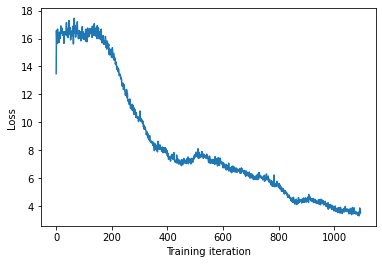

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.43it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.8 0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


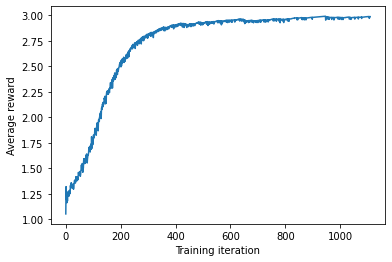

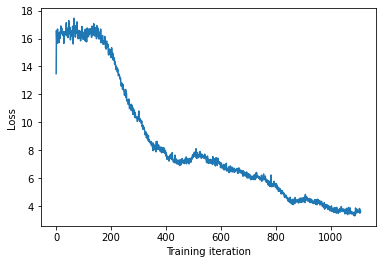

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.31it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:12,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.07it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


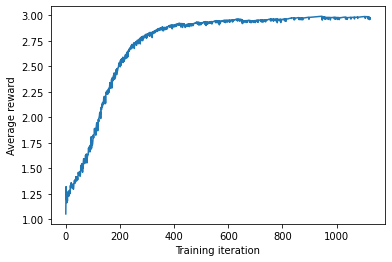

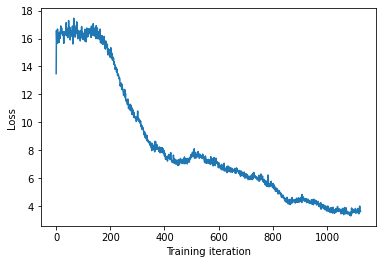

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.75it/s]


[0.  0.  1.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1C=CC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


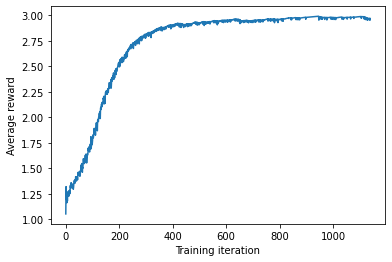

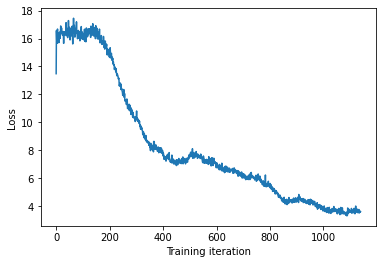

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 82.67it/s]


[0.  0.  0.2 0.4 0.  0.  0.  0.  0.  0.  0.8 0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C=C1CC1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


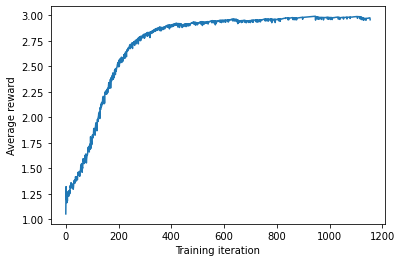

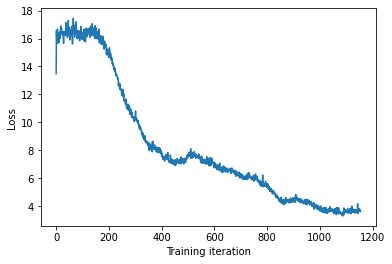

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.34it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.8 0.  0.  0. ]
Sample trajectories:
C1CC1
CC1CC1
CC1CC1C
CC1CCC1
CC1CCO1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


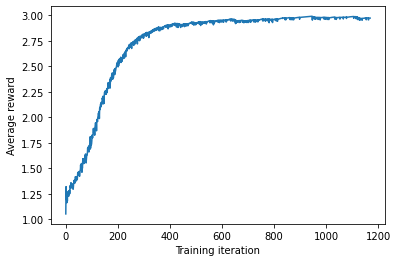

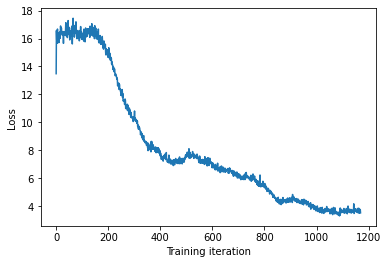

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 77.61it/s]


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1=CCC1
C1CC1
C1CCC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


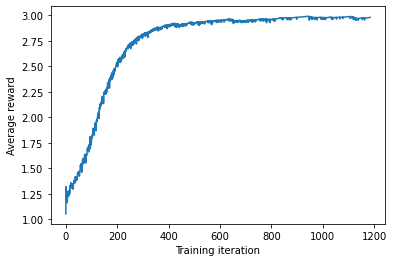

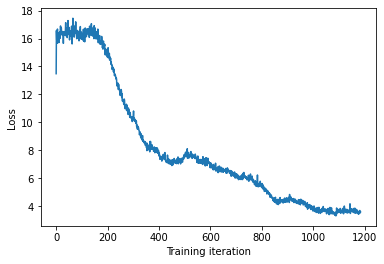

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 82.10it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CC1O


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


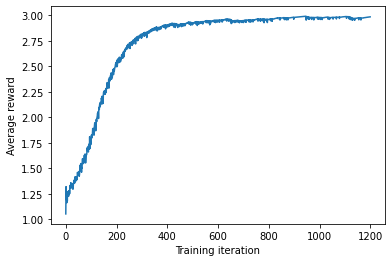

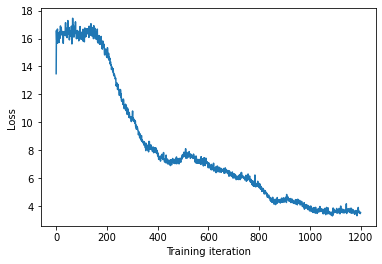

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.01it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CCC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.11it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:12<00:00,  1.11it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


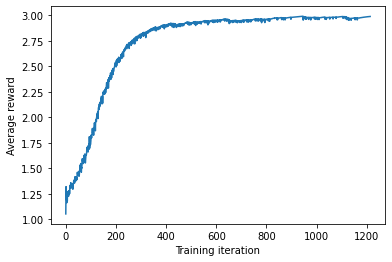

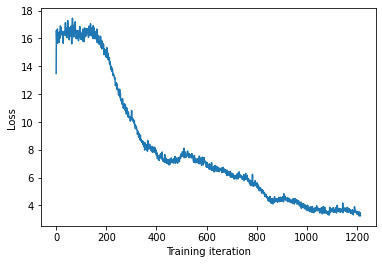

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 84.20it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:12,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


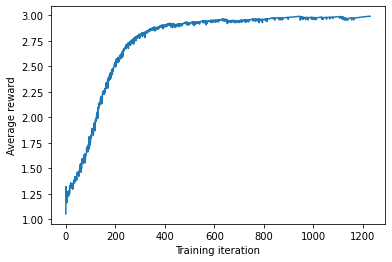

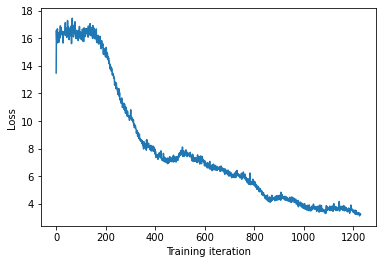

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 82.74it/s]


[0.  0.  0.2 0.6 0.  0.  0.  0.  0.8 0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C1Cn1
CC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:02,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


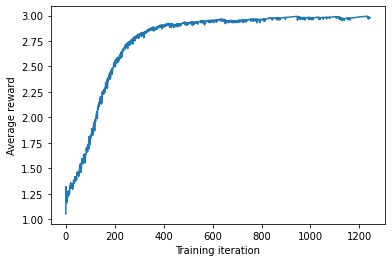

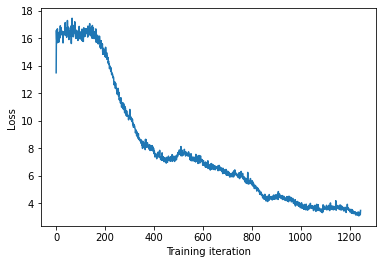

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 78.85it/s]


[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1BCC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.05it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


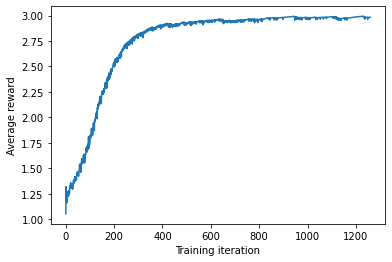

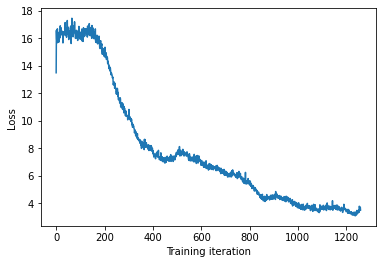

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.23it/s]


[0.  0.  0.2 0.  0.  0.  0.  0.6 0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:11,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


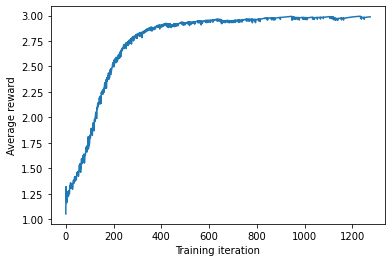

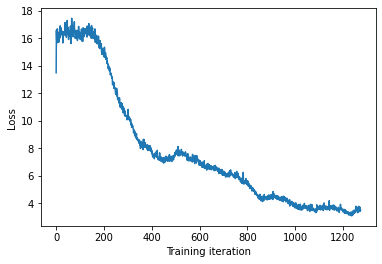

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.83it/s]


[0.  0.  0.  0.  0.  0.  0.8 0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CCC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


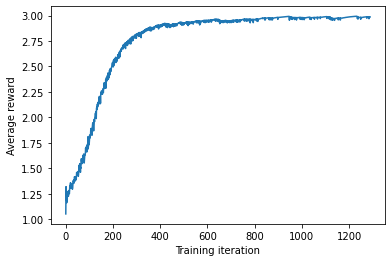

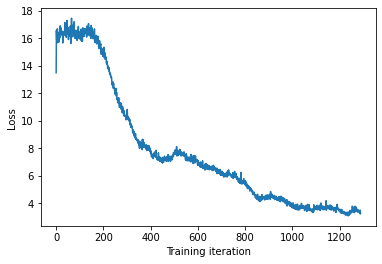

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 82.01it/s]


[0.  0.  0.6 0.  0.  0.  1.  0.  0.  0.6 0. ]
Sample trajectories:
C1CC1
C1CCC1
C1Cn1
CC1CC1
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


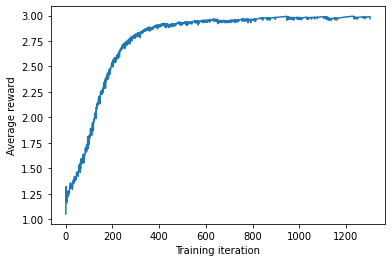

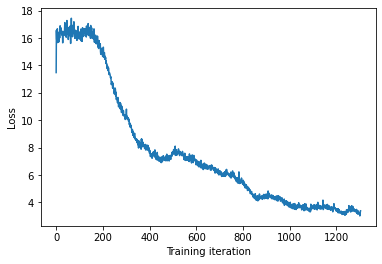

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.56it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


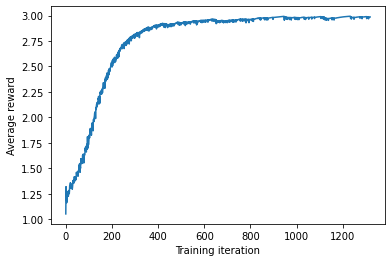

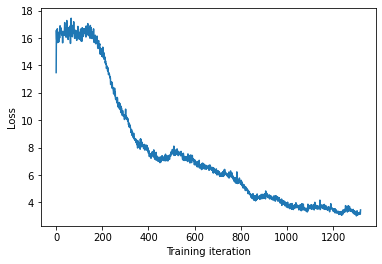

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 79.42it/s]


[0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


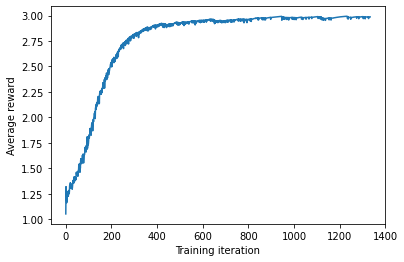

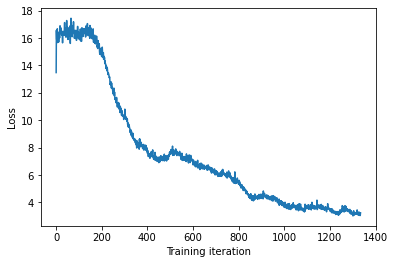

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.32it/s]


[0.  0.  0.  0.  0.  0.  0.8 1.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CC1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.6]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


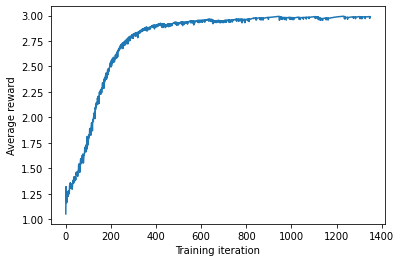

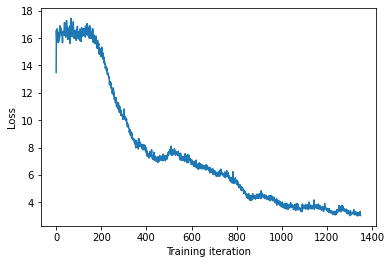

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.26it/s]


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CCC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.4]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


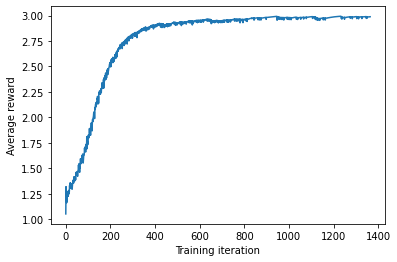

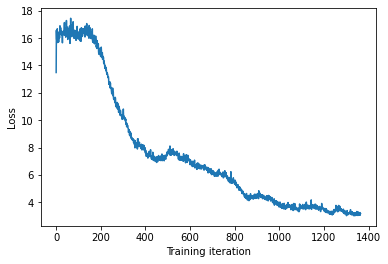

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 82.03it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:12,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:12<00:00,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


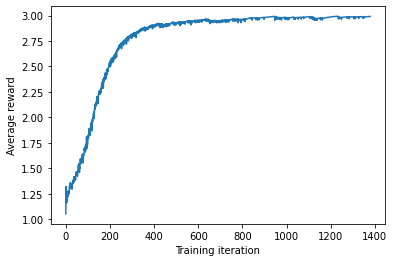

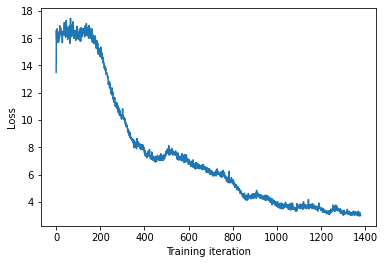

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 80.29it/s]


[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Sample trajectories:
C1CC1
CC1CC1
CC1CC1C
CC1CC1S
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:09,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:06,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.11s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.11s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


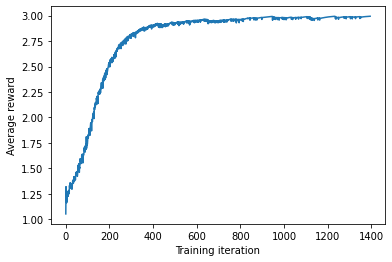

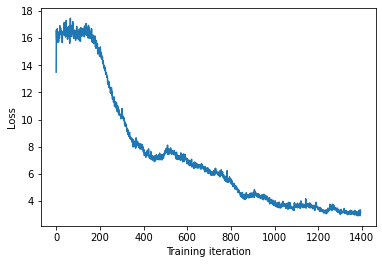

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 69.90it/s]


[0.  0.  0.  0.  0.  0.8 0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CC1CCC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.06s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.05s/it]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.11s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.14s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.08s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.8]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


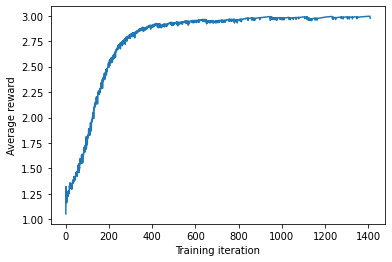

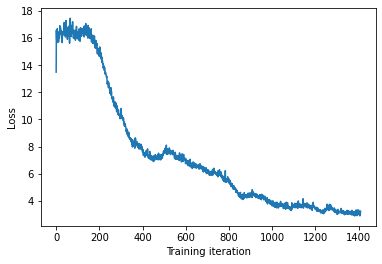

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 73.26it/s]


[0.  0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.8]
Sample trajectories:
C1CC1
C1CCC1
C=C1CC1
CC1CC1
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.01s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.00s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


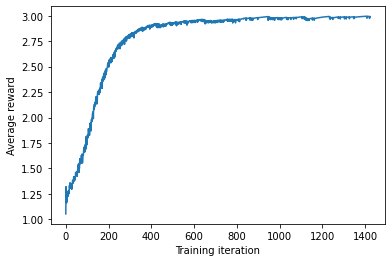

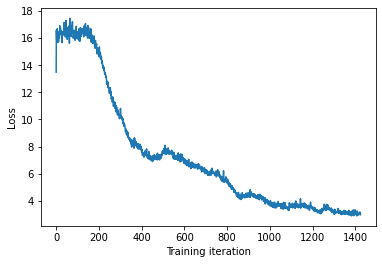

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 75.93it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.2]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


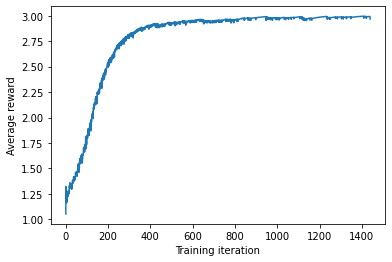

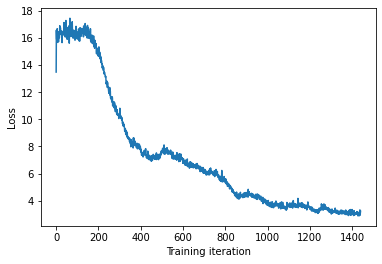

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 77.25it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
C1CCOC1
CC1CC1
CC1CC1C


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.03s/it]

[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:10,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.03s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:06,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:09<00:05,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.02s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.04s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.01s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


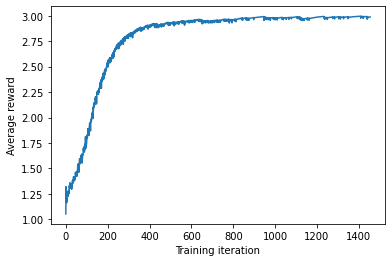

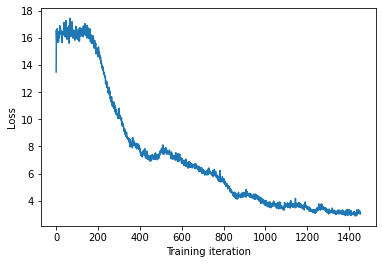

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 75.34it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CC1C
CC1CCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.08it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.09it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.10it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


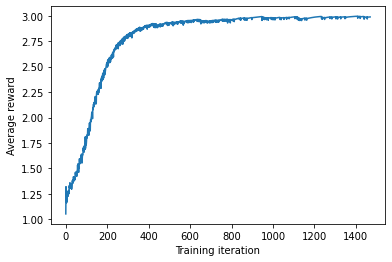

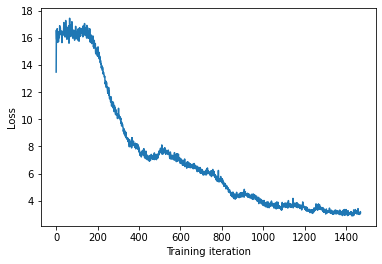

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 81.53it/s]


[0. 0. 0. 0. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
CC1CC1
CC1CC1C
CC1CCC1
CC1CCCC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.04it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.06it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.02it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.00it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.01it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


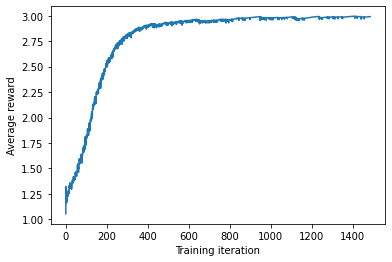

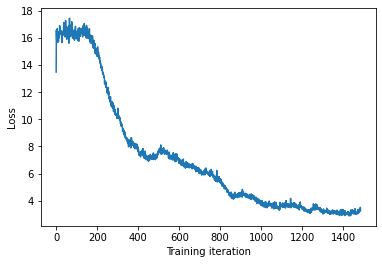

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 62.50it/s]


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Sample trajectories:
C1CC1
C1CCC1
CC1CC1
CC1CCC1
CCC1CC1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.15s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  13%|█▎        | 2/15 [00:02<00:15,  1.22s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.21s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.18s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.13s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:07,  1.11s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.14s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.15s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[1.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.12s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[]
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.10s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.07s/it]

[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []
[0.]
prop length 1 0 rewlist []


Policy gradient...: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


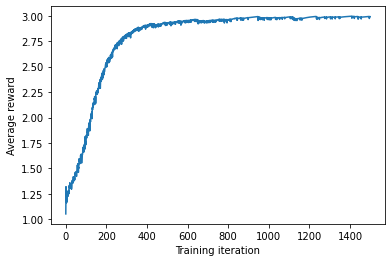

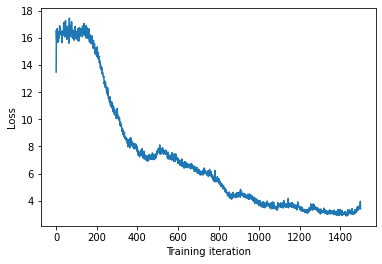

Generating molecules...: 100%|██████████| 200/200 [00:02<00:00, 71.69it/s]


[0.  0.  0.2 1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Sample trajectories:
C1CC1
C1CCC1
C1CCCC1
C=CC1CC1
CC1CC1


In [96]:
# Running policy gradient to estimate and update rewards and losses 
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_tox21.policy_gradient(gen_data, get_features=get_fp)
        rewards_max.append(simple_moving_average(rewards_max, cur_reward)) 
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))
    
    plt.plot(rewards_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses_max)
    
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_tox21.generator, 
                                                     my_predictor, 
                                                     n_to_generate,
                                                     get_features=get_fp)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)


In [97]:
# Print the last loss
print("last loss",rl_losses_max[-1] )
#Print the last reward
print("last reward", rewards_max[-1])

last loss 3.4006224677325383
last reward 2.9911725912604625


In [98]:
# Generate SMILES from biased RL model and corresponding predictions from RL model
# Estimate and Update for n iterations
smiles_biased_max, prediction_biased_max = estimate_and_update(RL_tox21.generator, 
                                                           my_predictor,
                                                           n_to_generate=10000)

Generating molecules...: 100%|██████████| 10000/10000 [02:03<00:00, 80.74it/s]


[0.2 0.6 0.  0.  0.2 0.  0.6 0.6 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.6
 0.2 1.  0.8 1.  0.  0.  1.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.8
 0.6 0.  0.  0.  0.  0.8 0.6 0.8 0.8 0.  0.  0.  0.  0.  1.  0.6 0.  0.
 1.  0.8 0.  0.6 0.2 0.6 0.8 0.4 0.8 1.  0.8 1.  1.  1.  0.  0.  0.  0.
 0.  0.  0.  1. ]


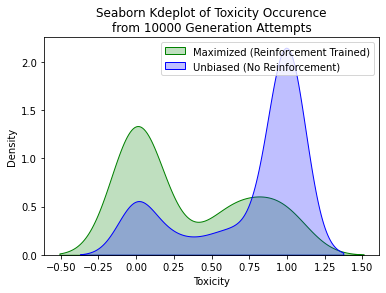

In [99]:
# Plot displaying toxicity of molecules produced before and after Reinforcement learning with a reward
sns.kdeplot(prediction_biased_max,label='Maximized (Reinforcement Trained)', shade=True, color='green')
sns.kdeplot(prediction_unbiased, label='Unbiased (No Reinforcement)', shade=True, color='blue')
plt.title('Seaborn Kdeplot of Toxicity Occurence\nfrom 10000 Generation Attempts')
plt.xlabel('Toxicity')
plt.ylabel('Density')
plt.legend()
plt.show()

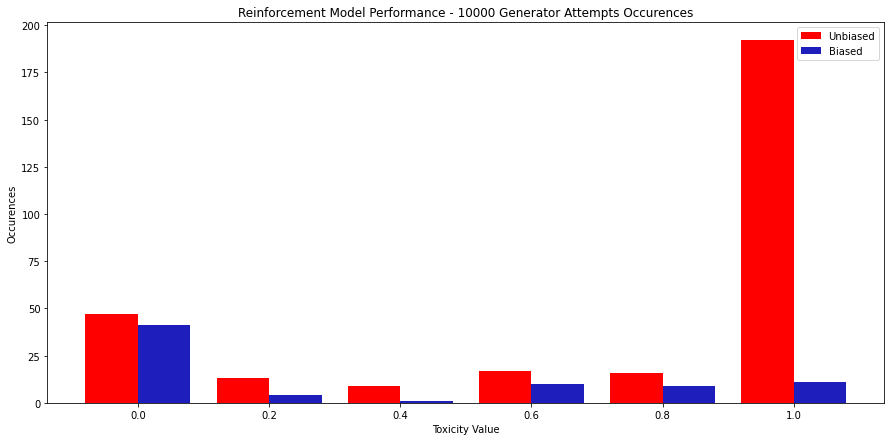

In [126]:
"""Display proportions of ALL molecules generated"""

import numpy as np
import matplotlib.pyplot as plt 
possiblevalues = np.linspace(0,1,6)
amt_unbiased = np.zeros(len(possiblevalues))
amt_biased = np.zeros(len(possiblevalues))
for i, val in enumerate(possiblevalues):
  amt_unbiased[i] = np.count_nonzero(prediction_unbiased == val)
  amt_biased[i] = np.count_nonzero(prediction_biased_max == val)

modelnames = ["Unbiased", "Biased"]
allmetrics_ALL = [amt_unbiased, amt_biased] 
label_text = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

colornames = ['red','#1e1ebd']

#original_colornames = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'maroon']

X_axis = np.arange(len(amt_biased))
  
totalwidth = 0.8

nmodels = len(modelnames)  
widthval = totalwidth / nmodels
leftedge = (widthval - totalwidth) / 2
rightedge = 0 - leftedge
centers = np.linspace(leftedge,rightedge,nmodels)

fig = plt.subplots(figsize =(15, 7))

for indexval, itemval in enumerate(modelnames):
    plt.bar(X_axis + centers[indexval], allmetrics_ALL[indexval], widthval, label = itemval, color = colornames[indexval])

plt.xticks(X_axis, label_text)
plt.xlabel("Toxicity Value")
plt.ylabel("Occurences")
plt.title("Reinforcement Model Performance - 10000 Generator Attempts Occurences")
plt.legend()
plt.show()

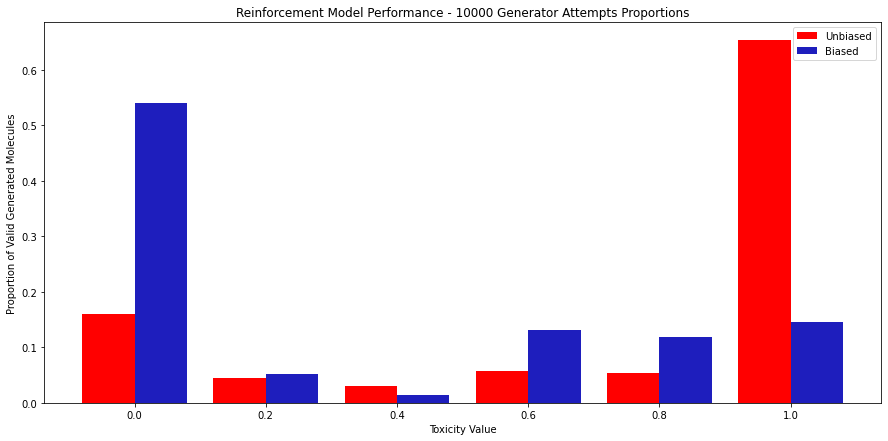

In [127]:
""" Display proportions of VALID molecules generated"""
# Not valid 
import numpy as np
import matplotlib.pyplot as plt 
possiblevalues = np.linspace(0,1,6)

sum_unbiased = np.sum(amt_unbiased)
amt_unbiased = amt_unbiased / sum_unbiased
sum_biased = np.sum(amt_biased)
amt_biased = amt_biased / sum_biased

# for i, val in enumerate(possiblevalues):
#   amt_unbiased[i] = np.count_nonzero(prediction_unbiased == val)
#   amt_biased[i] = np.count_nonzero(prediction_biased_max == val)

modelnames = ["Unbiased", "Biased"]
allmetrics_ALL = [amt_unbiased, amt_biased] 
label_text = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

colornames = ['red','#1e1ebd']

#original_colornames = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'maroon']

X_axis = np.arange(len(amt_biased))
  
totalwidth = 0.8

nmodels = len(modelnames)  
widthval = totalwidth / nmodels
leftedge = (widthval - totalwidth) / 2
rightedge = 0 - leftedge
centers = np.linspace(leftedge,rightedge,nmodels)

fig = plt.subplots(figsize =(15, 7))

for indexval, itemval in enumerate(modelnames):
    plt.bar(X_axis + centers[indexval], allmetrics_ALL[indexval], widthval, label = itemval, color = colornames[indexval])

plt.xticks(X_axis, label_text)
plt.xlabel("Toxicity Value")
plt.ylabel("Proportion of Valid Generated Molecules")
plt.title("Reinforcement Model Performance - 10000 Generator Attempts Proportions")
plt.legend()
plt.show()

With these bar plots we show that the biased (Reinforcement trained model) skews towards producing non toxic molecules in that their proportion of non toxic molecules goes up however they produce less valid molecules overall as seen by the amount of valid molecules decreasing after reinforcement learning.

The reason all toxicity values lie on increments of 0.2 is due to the predictions being the average of 5 classifiers from the 5 predictions from the cross validation sets.

In [103]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

# Define Molecule Viewing Conditions
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

RL model crating new UNBIASED molecules and printing them with their toxicity - Reward function NOT present

In [104]:
# Generate unbiased molecules
unbiased_generated_mols_max = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_unbiased]
# Sanitize molecules to only Valid molecules
unbiased_sanitized_gen_mols_max = [unbiased_generated_mols_max[i] 
                          for i in np.where(np.array(unbiased_generated_mols_max) != None)[0]]
                          
print(unbiased_sanitized_gen_mols_max)

[<rdkit.Chem.rdchem.Mol object at 0x7f30659f4740>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f45f0>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4270>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4ba0>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4350>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4900>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4970>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4190>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4820>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4040>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4890>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4dd0>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4f90>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4eb0>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4e40>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f40b0>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4f20>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4a50>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f4c10>, <rdkit.Chem.rdchem.Mol object at 0x7f30659f43c0>,

In [105]:
n_to_draw = 20
# Indices of molecules to draw
ind = np.random.randint(0, len(unbiased_sanitized_gen_mols_max), n_to_draw)
#Unbiased Molecules to draw
unbiased_mols_to_draw_max = [unbiased_sanitized_gen_mols_max[i] for i in ind]
legends = ['Toxicity = ' + str(prediction_unbiased[i]) for i in ind]


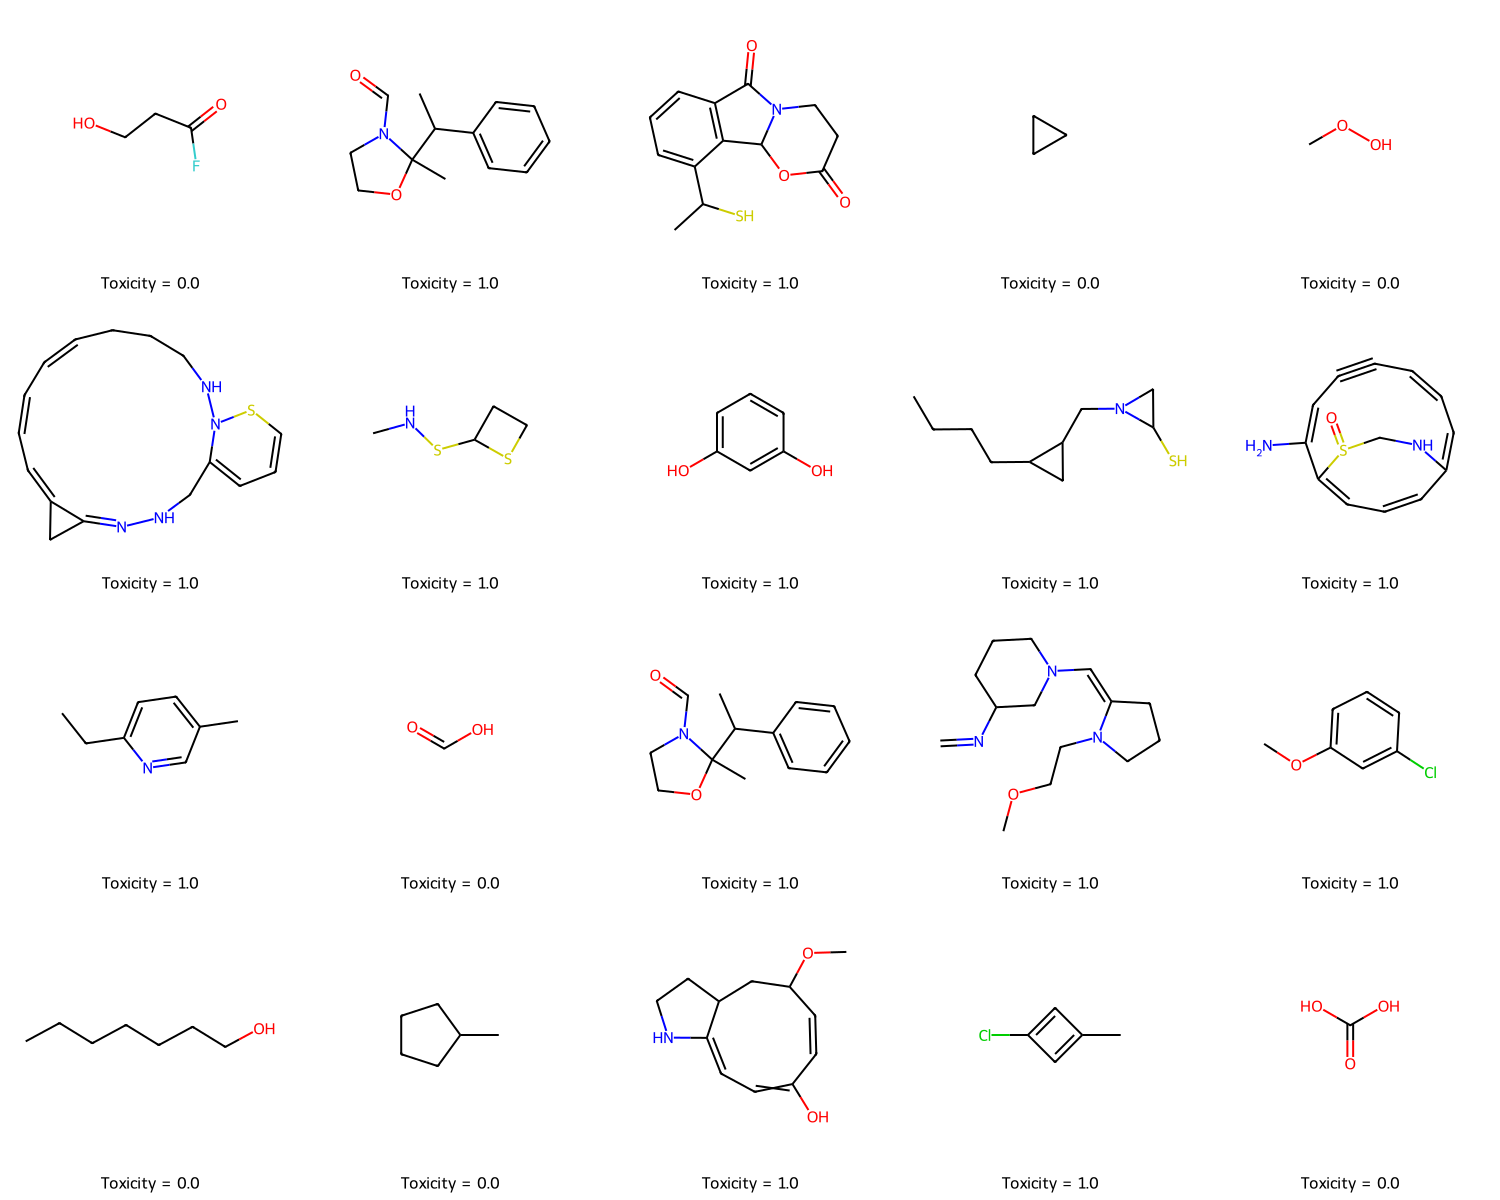

In [106]:
# Draw molecules from sample
print()
Draw.MolsToGridImage(unbiased_mols_to_draw_max, molsPerRow=5, 
                     subImgSize=(300,300), legends=legends)

In [ ]:
# # Generate Unbiased molecules
# generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_unbiased]
# sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]
# n_to_draw = 20
# print(len(sanitized_gen_mols))
# ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
# mols_to_draw = [sanitized_gen_mols[i] for i in ind]
# legends = ['Toxicity = ' + str(prediction_unbiased[i]) for i in ind]
# Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
#                      subImgSize=(200,200), legends=legends)

RL model creating new molecules and printing them with their toxicity- Reward function present

In [107]:
# Generate Biased Molecules
generated_mols_max = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased_max]
# Remove all novel molecules that are invalid
sanitized_gen_mols_max = [generated_mols_max[i] 
                          for i in np.where(np.array(generated_mols_max) != None)[0]]
print(sanitized_gen_mols_max)

[<rdkit.Chem.rdchem.Mol object at 0x7f30e058d190>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad580>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad510>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad5f0>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad660>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad6d0>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad740>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad7b0>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad820>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad890>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad900>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad970>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ad9e0>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06ada50>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06adac0>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06adb30>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06adba0>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06adc10>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06adc80>, <rdkit.Chem.rdchem.Mol object at 0x7f31c06adcf0>,

In [108]:
n_to_draw = 20
# Indices randomized 
ind = np.random.randint(0, len(sanitized_gen_mols_max), n_to_draw)
#Biased molecules to draw
mols_to_draw_max = [sanitized_gen_mols_max[i] for i in ind]
legends = ['Toxicity = ' + str(prediction_biased_max[i]) for i in ind]


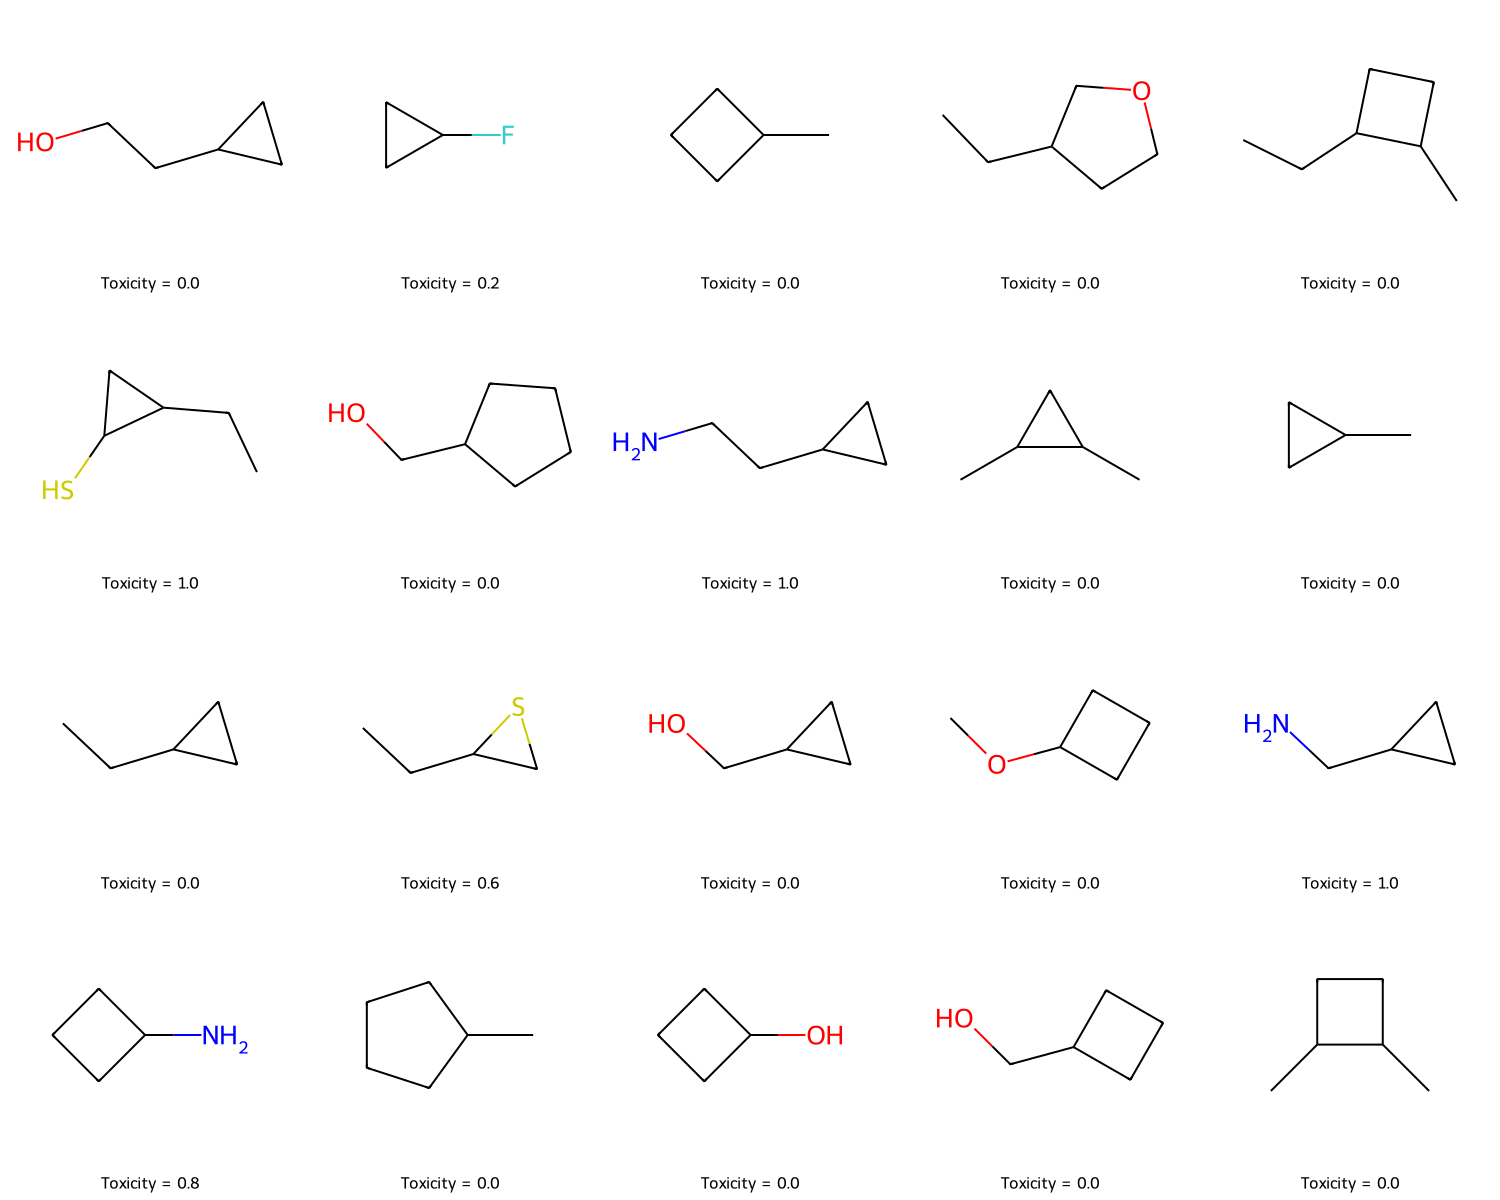

In [109]:
# Draw molecules to image
Draw.MolsToGridImage(mols_to_draw_max, molsPerRow=5, 
                     subImgSize=(300,300),legends=legends)

With these two samples of generated molecules we show that we are generating less toxic molecules but also that the molecules become simple in structure compared to the molecules generated without reinforcement learning.

In [ ]:
# generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased_max]
# sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]
# n_to_draw = 20
# print(len(sanitized_gen_mols))
# ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
# mols_to_draw = [sanitized_gen_mols[i] for i in ind]
# legends = ['Toxicity = ' + str(prediction_biased_max[i]) for i in ind]
# Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
#                      subImgSize=(200,200), legends=legends)